# Plot probability density of CWV, precip, SST, and surface winds
- CWV from radiosondes
- Precip from SEA-POL (disdrometer also available)
- SST from sea snake (TSG also available)
- Surface winds from DSHIP
- CAPE from radiosondes

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from thermo_functions import *
from orcestra_read_data import *
import glob
import os

In [2]:
#Set start and end times
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T22:59:00')

#Set E/W boundary
lonEW = -40
lonC = -30

# DSHIP data

In [3]:
#Open ship data
#DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
#CID: QmSSrT1UdtocfQS5yWSHFEJwJjqcNXjq2F1QfvNgLuEqSN
DSHIP= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
Data variables: (12/39)
    PM1               (time) float64 472kB ...
    PM10              (time) float64 472kB ...
    PM2p5             (time) float64 472kB ...
    lwr               (time) float64 472kB ...
    p_air             (time) float64 472kB ...
    rh_board          (time) float64 472kB ...
    ...                ...
    wdir              (time) float64 472kB ...
    wdir_rel          (time) float64 472kB ...
    wspd              (time) float64 472kB ...
    wspd_kn           (time) float64 472kB ...
    wspd_rel          (time) float64 472kB ...
    wspd_rel_kn       (time) float64 472kB ...
Attributes:
    creator_email:  hans.segura@mpimet.mpg.de
    creator_name:   Hans Segura
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    source:         DVS DShip
    title:          Ship information database (DVS DShip) of METEOR cruise M203

In [4]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

In [5]:
#Interpolate DSHIP data to hourly resolution
#could use 30 minute for IMERG, but MIMIC-TPW and ERA-5 are only hourly

ship_time_interp = pd.date_range(start_time, end_time, freq='h')
ship_lat_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lat)
ship_lon_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lon)

In [6]:
# Smooth wind speed and SST with an hourly running mean, restrict to the time period of interest
wspd_smoothed = DSHIP.wspd[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
#sst_smoothed = DSHIP.sst_port[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
shipLON = DSHIP.lon[index_start:index_end+1]
shipLAT = DSHIP.lat[index_start:index_end+1]
shipTIME = DSHIP.time[index_start:index_end+1]

#Find time when ship crosses 40W
iEW = np.where(shipLON <= lonEW)[0]
iEW = int(iEW[0])
timeEW = shipTIME[iEW]

# Split into East/West
wspd_smoothedE = wspd_smoothed.where(shipLON > lonEW, drop=True)
wspd_smoothedW = wspd_smoothed.where(shipLON <= lonEW, drop=True)
#sst_smoothedE = sst_smoothed.where(shipLON > lonEW, drop=True)
#sst_smoothedW = sst_smoothed.where(shipLON <= lonEW, drop=True)

# Calibrated Thermosalinograph Data

In [7]:
#tsg = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Dship_data/data/M203_surf_oce.nc') #un-calibrated
#tsg = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Dship_data/data/met_203_1_tsal.nc') #calibrated
#CID: QmZSVETjZ38bYHBQBMjyEadqUtE93GVqAmLCaePeDkdDoy
tsg= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/thermosalinograph/met_203_1_tsal.zarr',engine='zarr')
tsg

<xarray.Dataset> Size: 3MB
Dimensions:       (Depth: 1, TIME: 56467)
Coordinates:
  * TIME          (TIME) datetime64[ns] 452kB 2024-08-16T02:53:00 ... 2024-09...
Dimensions without coordinates: Depth
Data variables:
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    LATITUDE      (TIME) float64 452kB ...
    LATITUDE_QC   (TIME) int8 56kB ...
    LONGITUDE     (TIME) float64 452kB ...
    LONGITUDE_QC  (TIME) int8 56kB ...
    PSAL          (Depth, TIME) float64 452kB ...
    PSAL_QC       (Depth, TIME) float64 452kB ...
    TEMP          (Depth, TIME) float64 452kB ...
    TEMP_QC       (Depth, TIME) float64 452kB ...
Attributes: (12/56)
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    area:                            tropical Atlantic Ocean
    cdm_data_type:                   Trajectory
    comment:                         R/V Meteor is equipped with two thermosa...
    ...                              ...
    time_coverage_resolution:        60
    time_coverage_start:             2024-08-16T02:53:00Z
    time_coverage_units:             s
    title:                           Continuous thermosalinograph salinity an...
    update_interval:                 void
    vessel:                          R/V Meteor (IMO:06M320240810)

In [8]:
# Find time indices for start and end times
i1_TSG = np.abs(tsg.TIME - start_time).argmin()
i1_TSG = int(i1_TSG)

i2_TSG = np.abs(tsg.TIME - end_time).argmin()
i2_TSG = int(i2_TSG)

In [9]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed = tsg.TEMP[0,i1_TSG:i2_TSG+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean

#Split into East/West
iEW_TSG = np.abs(tsg.TIME[i1_TSG:i2_TSG+1] - timeEW).argmin()
iEW_TSG = int(iEW_TSG)

sst_smoothedE = sst_smoothed[0:iEW_TSG] 
sst_smoothedW = sst_smoothed[iEW_TSG:]                                  

# Calibrated Sea Snake Data

In [7]:
#snake = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/SeaSnake/seaSnakeData_calibrated/met_203_1_SeaSnake.nc')
#CID: QmXvjfzggSLwRvLyrhAo7X9o6wkHaciKRPWdGQ3fxXMzrU
snake = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/SeaSnake/met_203_1_SeaSnake.zarr',engine='zarr')
snake

<xarray.Dataset> Size: 2MB
Dimensions:       (Depth: 1, TIME: 46811)
Coordinates:
  * TIME          (TIME) datetime64[ns] 374kB 2024-08-21T09:21:35.812525 ... ...
Dimensions without coordinates: Depth
Data variables:
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    LATITUDE      (TIME) float64 374kB ...
    LATITUDE_QC   (TIME) int8 47kB ...
    LONGITUDE     (TIME) float64 374kB ...
    LONGITUDE_QC  (TIME) int8 47kB ...
    TEMP          (Depth, TIME) float64 374kB ...
    TEMP_QC       (Depth, TIME) float64 374kB ...
Attributes: (12/56)
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    area:                            tropical Atlantic Ocean
    cdm_data_type:                   Trajectory
    comment:                         The SeaSnake consists of a slow-response...
    ...                              ...
    time_coverage_resolution:        60
    time_coverage_start:             2024-08-21T09:21:35Z
    time_coverage_units:             s
    title:                           Continuous subskin sea surface temperatu...
    update_interval:                 void
    vessel:                          R/V Meteor (IMO:06M320240810)

In [8]:
# Find time indices for start and end times
i1_snake = np.abs(snake.TIME - start_time).argmin()
i1_snake = int(i1_snake)

i2_snake = np.abs(snake.TIME - end_time).argmin()
i2_snake = int(i2_snake)

In [9]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed2 = snake.TEMP[0,i1_snake:i2_snake+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean

#Split into East/West
iEW_snake = np.abs(snake.TIME[i1_snake:i2_snake+1] - timeEW).argmin()
iEW_snake = int(iEW_snake)

sst_smoothedE2 = sst_smoothed2[0:iEW_snake] 
sst_smoothedW2 = sst_smoothed2[iEW_snake:]                                  

SST time series

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_4200/2947991179.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(DSHIP.time[index_start:index_end+1], snake_interp-TSG_interp, c=c, s=5, cmap='viridis', label='Ship Speed')


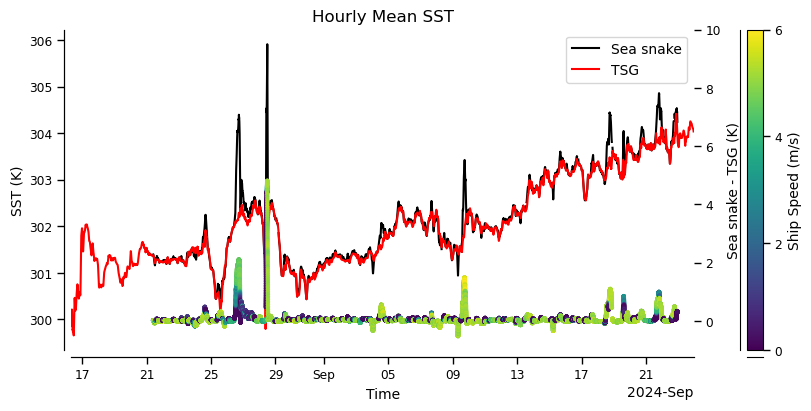

In [19]:
fig,ax = plt.subplots(figsize=(8,4),layout="constrained")

ax.plot(snake.TIME[i1_snake:i2_snake+1],sst_smoothed2,'k',label='Sea snake',zorder=1)
ax.plot(tsg.TIME[i1_TSG:i2_TSG+1],sst_smoothed,'red',label='TSG',zorder=2)

ax.set_xlim(start_time,end_time)  

plt.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel('Time')
ax.set_ylabel('SST (K)')
ax.set_title('Hourly Mean SST')

#two y-panels
ax2 = ax.twinx()
#color by ship speed
#hourly mean ship speed
shipspd_smoothed= DSHIP.ship_speed.rolling(time=60, center=True).mean()
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=0, vmax=6)
c = cmap(norm(DSHIP.ship_speed[index_start:index_end+1]))

#interpolate sst_smoothed2 onto DSHIP.time
snake_interp= np.interp(DSHIP.time[index_start:index_end+1],snake.TIME[i1_snake:i2_snake+1],sst_smoothed2)
#interpolate sst_smoothed onto DSHIP.time
TSG_interp= np.interp(DSHIP.time[index_start:index_end+1],tsg.TIME[i1_TSG:i2_TSG+1],sst_smoothed)
ax2.scatter(DSHIP.time[index_start:index_end+1], snake_interp-TSG_interp, c=c, s=5, cmap='viridis', label='Ship Speed')
ax2.set_ylabel('Sea snake - TSG (K)')
ax2.set_ylim(-1,10)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax2, pad=0.01)
cbar.set_label('Ship Speed (m/s)')
cbar.set_ticks([0, 2, 4, 6])
cbar.set_ticklabels(['0', '2', '4', '6'])



sns.set_context('paper') 
sns.despine(offset=5)

fig.savefig('../../figures/Fig_SST_snake_TSG.png')

(0.0, 6.0)

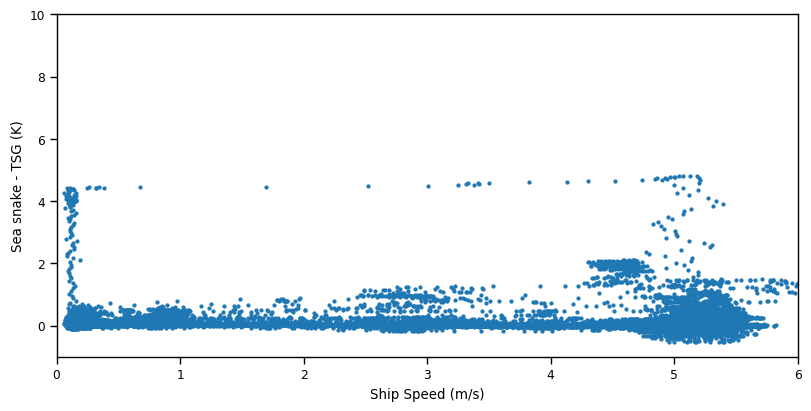

In [20]:
# scatterplot of sea snake - TSG vs ship speed
fig,ax = plt.subplots(figsize=(8,4),layout="constrained")
ax.scatter(DSHIP.ship_speed[index_start:index_end+1], snake_interp-TSG_interp, s=5, label='Ship Speed')
ax.set_xlabel('Ship Speed (m/s)')
ax.set_ylabel('Sea snake - TSG (K)')
ax.set_ylim(-1,10)
ax.set_xlim(0,6)


# Radiosonde data

In [10]:
#root_radio = 'https://ipfs.io/ipfs/QmSUUUPcGcpwdJJCVDGPGYksLsqkWbfh6d6xFcTk2Qu7Zf'
#CID: QmbZQh6TcKVaWLj2x5UxqJ2nWcY3He1qwpsVQjCcUip7wq
root_radio = 'ipns://latest.orcestra-campaign.org/products/Radiosondes'
dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")

snd_asc = read_soundings(platform='RV_Meteor', ascent=0) #Read ascending soundings

# Mask soundings that don't reach 100 hPa
snd_asc, min_pres = mask_soundings(snd_asc, p_threshold=100)

times_asc = snd_asc['times']
hght = snd_asc['hght']

Define functions

In [11]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
#def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
#    rho = density_moist(tmpk, mr, p) # kg/m3
#    dz = hght[1]-hght[0] # m
#    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
#    var_int[ np.where(var_int == 0) ] = np.nan
#    return var_int

def vert_integral(tmpk, mr, p, hght, minpres=0):
    sh = mixr2sh(mr)
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * tmpk * (1. + mr*eps_r)/(1.+mr) )
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(sh*rho, axis=1)*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


Calculate column-integrated water vapor

In [12]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [13]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght) # mm or kg/m2

In [14]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Find longitude by interpolating time of sounding to ship time
sondeLON = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lon)

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)
sondeLON = np.ma.masked_where(times_asc < start_time, sondeLON, copy=False)

# Split into east and west
cwvE = cwv[sondeLON > lonEW]
cwvW = cwv[sondeLON <= lonEW]

In [15]:
finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]

finite = np.where(np.isfinite(cwvE))
cwvE_finite = cwvE[finite]

finite = np.where(np.isfinite(cwvW))
cwvW_finite = cwvW[finite]

Calculate CAPE

In [16]:
cape,cin = get_cape_cin(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'], type='sfc')

# Mask out soundings before start_time
cape = np.ma.masked_where(times_asc < start_time, cape, copy=False)

#Mask out soundings that don't reach 100 hPa
cape = np.ma.masked_where((min_pres > 100), cape, copy=False)

#split into east and west
capeE = cape[sondeLON > lonEW]
capeW = cape[sondeLON <= lonEW]

finite = np.where(np.isfinite(cape))
cape_finite = cape[finite]

finite = np.where(np.isfinite(capeE))
capeE_finite = capeE[finite]

finite = np.where(np.isfinite(capeW))
capeW_finite = capeW[finite]

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/ma/core.py:7229: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/awing/orcestra/code/PICCOLO/thermo_functions.py:181: RuntimeWarning: overflow encountered in exp
  * np.exp( (lv0 - (cpl-cpv)*((T+T0)-273.15))*rv / ((cp + cpl*rtot)*(T+T0)) )


Calculate shear

In [17]:
# Calculate 0-6km shear
nt = times_asc.size
shear06 = np.zeros(nt)
pres06 = np.zeros(nt)
iz1 = np.where(hght == 6e3)[0][0]
iz0=1 # 10 m
for it in range(nt):
    shear06[it] = np.sqrt( (snd_asc['u'][it,iz1] - snd_asc['u'][it,iz0])**2 + (snd_asc['v'][it,iz1] - snd_asc['v'][it,iz0])**2 )
    pres06[it] = snd_asc['p'][it,iz1]

In [39]:
# Replace 0-6 km shear with 0-600 hPa shear
nt = times_asc.size
shear06 = np.zeros(nt)
iz0=1 # 10 m
for it in range(nt):
    # Find the index where snd_asc['p'] is closest to 60000
    iz1 = abs(snd_asc['p'][it] - 60000).argmin()
    shear06[it] = np.sqrt( (snd_asc['u'][it,iz1] - snd_asc['u'][it,iz0])**2 + (snd_asc['v'][it,iz1] - snd_asc['v'][it,iz0])**2 )

In [18]:
# Mask out soundings before start_time
shear06 = np.ma.masked_where(times_asc < start_time, shear06, copy=False)

#Mask out soundings that don't reach 100 hPa
shear06 = np.ma.masked_where((min_pres > 100), shear06, copy=False)

#split into east and west
shear06E = shear06[sondeLON > lonEW]
shear06W = shear06[sondeLON <= lonEW]

finite = np.where(np.isfinite(shear06))
shear06_finite = shear06[finite]

finite = np.where(np.isfinite(shear06E))
shear06E_finite = shear06E[finite]

finite = np.where(np.isfinite(shear06W))
shear06W_finite = shear06W[finite]

In [19]:
# Calculate 0-2km shear
nt = times_asc.size
shear02 = np.zeros(nt)
pres02 = np.zeros(nt)
iz1 = np.where(hght == 2e3)[0][0]
iz0=1 # 10 m
for it in range(nt):
    shear02[it] = np.sqrt( (snd_asc['u'][it,iz1] - snd_asc['u'][it,iz0])**2 + (snd_asc['v'][it,iz1] - snd_asc['v'][it,iz0])**2 )
    pres02[it] = snd_asc['p'][it,iz1]

In [44]:
# Replace 0-2 km shear with 0-850 hPa shear
nt = times_asc.size
shear02 = np.zeros(nt)
iz0=1 # 10 m
for it in range(nt):
    # Find the index where snd_asc['p'] is closest to 60000
    iz1 = abs(snd_asc['p'][it] - 85000).argmin()
    shear02[it] = np.sqrt( (snd_asc['u'][it,iz1] - snd_asc['u'][it,iz0])**2 + (snd_asc['v'][it,iz1] - snd_asc['v'][it,iz0])**2 )

In [20]:
# Mask out soundings before start_time
shear02 = np.ma.masked_where(times_asc < start_time, shear02, copy=False)

#Mask out soundings that don't reach 100 hPa
shear02 = np.ma.masked_where((min_pres > 100), shear02, copy=False)

#split into east and west
shear02E = shear02[sondeLON > lonEW]
shear02W = shear02[sondeLON <= lonEW]

finite = np.where(np.isfinite(shear02))
shear02_finite = shear02[finite]

finite = np.where(np.isfinite(shear02E))
shear02E_finite = shear02E[finite]

finite = np.where(np.isfinite(shear02W))
shear02W_finite = shear02W[finite]

# Precipitation data - disdrometer

In [21]:
#disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')
#CID: QmajLZ8KboBuGsVzUsKcnDVRbsZp3ybzepYPjLKcfhabcE
disdro = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/disdrometer/DSD_METEOR_merged.zarr',engine='zarr')
disdro

<xarray.Dataset> Size: 255MB
Dimensions:                       (time: 56160, particle_size: 32,
                                   raw_fall_velocity: 32)
Coordinates:
  * particle_size                 (particle_size) float32 128B 0.062 ... 24.5
  * raw_fall_velocity             (raw_fall_velocity) float32 128B 0.05 ... 20.8
  * time                          (time) datetime64[ns] 449kB 2024-08-16 ... ...
Data variables: (12/45)
    Nd                            (time, particle_size) float32 7MB ...
    adr_c                         (time) float32 225kB ...
    adr_s                         (time) float32 225kB ...
    adr_x                         (time) float32 225kB ...
    ai_c                          (time) float32 225kB ...
    ai_s                          (time) float32 225kB ...
    ...                            ...
    zdr_c                         (time) float32 225kB ...
    zdr_s                         (time) float32 225kB ...
    zdr_x                         (time) float32 225kB ...
    zh_c                          (time) float32 225kB ...
    zh_s                          (time) float32 225kB ...
    zh_x                          (time) float32 225kB ...
Attributes: (12/24)
    creator_email:                   delianb@colostate.edu
    creator_name:                    Delián Colón-Burgos
    featureType:                     trajectory
    history:                         converted to Zarr by Lukas Kluft (lukas....
    keywords:                        disdrometer, rainrate, parsivel, meteor,...
    license:                         CC-BY-4.0
    ...                              ...
    summary:                         The merged version contains data from th...
    title:                           Merged PARSIVEL Disdrometer QCed data
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    tmatrix_scattering_temperature:  20 C

In [22]:
# Calculate time frequency of precip (fraction of times within an hour with precip)
precip_freq_disdro = np.zeros_like(ship_time_interp, dtype=float)
for i, t in enumerate(ship_time_interp):
    # Find the indices of disdro data within the hour
    mask = (disdro.time >= t) & (disdro.time < t + np.timedelta64(1, 'h'))
    # Calculate the frequency of precip within that hour
    disdro_precip_mask = disdro.rain_rate_qc[mask]
    precip_freq_disdro[i] = np.sum(disdro_precip_mask > 0) / np.sum(mask)


In [23]:
# Calculate time frequency of precip (fraction of times within a day with precip)
ship_time_day = pd.date_range(start_time, end_time, freq='D')
precip_freq_disdro_daily = np.zeros_like(ship_time_day, dtype=float)
for i, t in enumerate(ship_time_day):
    # Find the indices of disdro data within the day
    mask = (disdro.time >= t) & (disdro.time < t + np.timedelta64(1, 'D'))
    # Calculate the frequency of precip within that day
    disdro_precip_mask = disdro.rain_rate_qc[mask]
    precip_freq_disdro_daily[i] = np.sum(disdro_precip_mask > 0) / np.sum(mask)

In [24]:
#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == start_time)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == end_time)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with an hourly running mean, restrict to the time period of interest
precip = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=60, center=True).mean() # 60 minute running mean
disdroLON = disdro.lon[index_start_disdro:index_end_disdro+1]
disdroLAT = disdro.lat[index_start_disdro:index_end_disdro+1]

In [25]:
#Split into east and west
precipE = precip[disdroLON > lonEW]
precipW = precip[disdroLON <= lonEW]

precip_freq_disdroE = precip_freq_disdro[ship_lon_interp > lonEW]
precip_freq_disdroW = precip_freq_disdro[ship_lon_interp <= lonEW]

precip_freq_disdro_dailyE = precip_freq_disdro_daily[ship_time_day < np.datetime64(timeEW.values)]
precip_freq_disdro_dailyW = precip_freq_disdro_daily[ship_time_day >= np.datetime64(timeEW.values)]

# Precipitation data - rain gauge

In [26]:
#CID: QmYQpz2ew8GYa58aED5h2ViYLWtq99bYWvxVNw7KuNaASs
gauge = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/rain_gauge/M203_Niederschlag_Stand_240923-2227.zarr',engine='zarr')
gauge

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 55628)
Coordinates:
    height   float64 8B ...
  * time     (time) datetime64[ns] 445kB 2024-08-16T07:19:00 ... 2024-09-23T2...
Data variables:
    DD       (time) int64 445kB ...
    Dauer    (time) int64 445kB ...
    FF       (time) float64 445kB ...
    Lat      (time) float64 445kB ...
    Long     (time) float64 445kB ...
    RH       (time) float64 445kB ...
    RR_SRM   (time) float64 445kB ...
    TT       (time) float64 445kB ...
    Tro1     (time) int64 445kB ...
    Trs      (time) int64 445kB ...
    VVV      (time) int64 445kB ...
Attributes:
    creator_email:  Martin.Stelzner@dwd.de, daniel.klocke@mpimet.mpg.de
    creator_name:   Martin Stelzner, Daniel Klocke
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    keywords:       precipitation amount, precipitation gauge, precipitation ...
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    summary:        The rain gauge has an upper and a lateral collecting surf...
    title:          Rain gauge measurements during METEOR cruise M203

In [27]:
# Calculate time frequency of precip (fraction of times within an hour with precip)
precip_freq_gauge = np.zeros_like(ship_time_interp, dtype=float)
for i, t in enumerate(ship_time_interp):
    # Find the indices of gauge data within the hour
    mask = (gauge.time >= t) & (gauge.time < t + np.timedelta64(1, 'h'))
    # Calculate the frequency of precip within that hour
    gauge_precip_mask = gauge.RR_SRM[mask]
    precip_freq_gauge[i] = np.sum(gauge_precip_mask > 0) / np.sum(mask)


In [28]:
# Calculate time frequency of precip (fraction of times within a day with precip)
precip_freq_gauge_daily = np.zeros_like(ship_time_day, dtype=float)
for i, t in enumerate(ship_time_day):
    # Find the indices of gauge data within the day
    mask = (gauge.time >= t) & (gauge.time < t + np.timedelta64(1, 'D'))
    # Calculate the frequency of precip within that day
    gauge_precip_mask = gauge.RR_SRM[mask]
    precip_freq_gauge_daily[i] = np.sum(gauge_precip_mask > 0) / np.sum(mask)

Text(0.5, 1.0, 'Frequency of 1-min Precipitation')

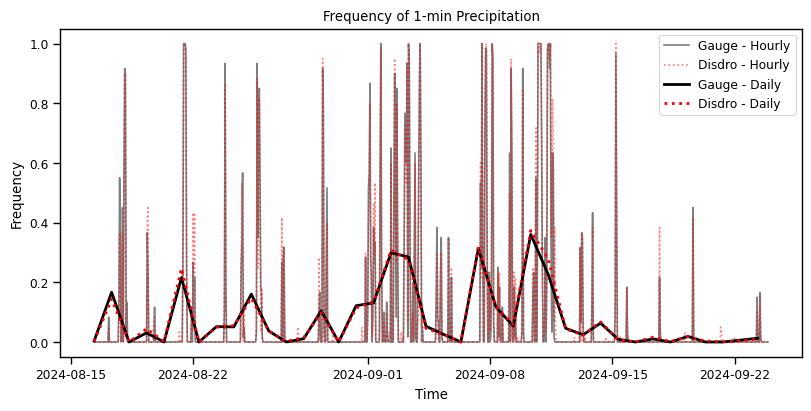

In [97]:
# plot precip frequency
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.plot(ship_time_interp, precip_freq_gauge, label='Gauge - Hourly', color = 'black', alpha = 0.5)
ax.plot(ship_time_interp, precip_freq_disdro, label='Disdro - Hourly', color = 'red', alpha = 0.5, linestyle = ':')
ax.plot(ship_time_day, precip_freq_gauge_daily, label='Gauge - Daily', color='black', linewidth = 2)
ax.plot(ship_time_day, precip_freq_disdro_daily, label='Disdro - Daily', color='red', linestyle = ':', linewidth = 2)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of 1-min Precipitation')


In [29]:
#Find indices for start and end times
index_start_gauge = np.where(pd.to_datetime(gauge.time) == start_time)[0]
index_start_gauge = int(index_start_gauge[0])

index_end_gauge = np.where(pd.to_datetime(gauge.time) == end_time)[0]
# if the end time is not found, use the last index
index_end_gauge = int(index_end_gauge[0]) if index_end_gauge.size > 0 else gauge.time.size - 1

# Smooth with an hourly running mean, restrict to the time period of interest
precip_gauge = gauge.RR_SRM[index_start_gauge:index_end_gauge+1].rolling(time=60, center=True).mean() # 60 minute running mean
gaugeLON = gauge.Long[index_start_gauge:index_end_gauge+1]
gaugeLAT = gauge.Lat[index_start_gauge:index_end_gauge+1]

In [30]:
#Split into east and west
precip_gaugeE = precip_gauge[gaugeLON > lonEW]
precip_gaugeW = precip_gauge[gaugeLON <= lonEW]

precip_freq_gaugeE = precip_freq_gauge[ship_lon_interp > lonEW]
precip_freq_gaugeW = precip_freq_gauge[ship_lon_interp <= lonEW]

precip_freq_gauge_dailyE = precip_freq_gauge_daily[ship_time_day < np.datetime64(timeEW.values)]
precip_freq_gauge_dailyW = precip_freq_gauge_daily[ship_time_day >= np.datetime64(timeEW.values)]

# Precipitation data - SEA-POL

In [31]:
#seapol = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means_masked.nc')
seapol = xr.open_dataset('../../data/SEA-POL_4b_rainrate_2D_spatial_means_masked.nc')
seapol

<xarray.Dataset> Size: 222kB
Dimensions:       (time: 4615)
Coordinates:
  * time          (time) datetime64[ns] 37kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain12_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain12_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

In [32]:
# fractional area coverage of precip (from Sarah)
#seapol_fa = xr.open_dataset('../../data/fractional_area.nc')
seapol_fa = xr.open_dataset('../../data/metric_radius_time.nc')
seapol_fa

<xarray.Dataset> Size: 4MB
Dimensions:             (time: 36981, thirty_min_time: 948, hourly_time: 477,
                         three_hourly_time: 166, six_hourly_time: 86,
                         twelve_hourly_time: 47, daily_time: 26)
Coordinates:
  * time                (time) datetime64[ns] 296kB 2024-08-29 ... 2024-09-23...
  * thirty_min_time     (thirty_min_time) datetime64[ns] 8kB 2024-08-29 ... 2...
  * hourly_time         (hourly_time) datetime64[ns] 4kB 2024-08-29 ... 2024-...
  * three_hourly_time   (three_hourly_time) datetime64[ns] 1kB 2024-08-29 ......
  * six_hourly_time     (six_hourly_time) datetime64[ns] 688B 2024-08-29 ... ...
  * twelve_hourly_time  (twelve_hourly_time) datetime64[ns] 376B 2024-08-29 ....
  * daily_time          (daily_time) datetime64[ns] 208B 2024-08-29 ... 2024-...
Data variables: (12/84)
    p_245km             (time) float64 296kB ...
    i_245km             (time) float64 296kB ...
    f_a_245km           (time) float64 296kB ...
    p_120km             (time) float64 296kB ...
    i_120km             (time) float64 296kB ...
    f_a_120km           (time) float64 296kB ...
    ...                  ...
    p_60km_daily        (daily_time) float64 208B ...
    i_60km_daily        (daily_time) float64 208B ...
    f_a_60km_daily      (daily_time) float64 208B ...
    p_12km_daily        (daily_time) float64 208B ...
    i_12km_daily        (daily_time) float64 208B ...
    f_a_12km_daily      (daily_time) float64 208B ...

In [33]:
# Restrict to After Praia
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
#indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()
indexAP = 0

# Smooth with an hourly running mean, seapol is already restricted to a time period within the time period of interest
precip2 = seapol.rain60_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip2int = seapol.rain60_int[indexAP:].rolling(time=6, center=True).mean()

precip_seapol1 = seapol.rain1_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip_seapol1int = seapol.rain1_int[indexAP:].rolling(time=6, center=True).mean()

precip_seapol12 = seapol.rain12_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip_seapol12int = seapol.rain12_int[indexAP:].rolling(time=6, center=True).mean()

precip_seapol120 = seapol.rain120_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip_seapol120int = seapol.rain120_int[indexAP:].rolling(time=6, center=True).mean()

precip_seapol245 = seapol.rain245_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip_seapol245int = seapol.rain245_int[indexAP:].rolling(time=6, center=True).mean()

In [34]:
#Split into East/West
iEW_seapol = np.abs(seapol.time[indexAP:] - timeEW).argmin()
iEW_seapol = int(iEW_seapol)

precipE2 = precip2[0:iEW_seapol] 
precipW2 = precip2[iEW_seapol:] 

precipE2int = precip2int[0:iEW_seapol]
precipW2int = precip2int[iEW_seapol:]

precip_seapol1E = precip_seapol1[0:iEW_seapol]
precip_seapol1W = precip_seapol1[iEW_seapol:]
precip_seapol1Eint = precip_seapol1int[0:iEW_seapol]                    
precip_seapol1Wint = precip_seapol1int[iEW_seapol:]

precip_seapol12E = precip_seapol12[0:iEW_seapol]
precip_seapol12W = precip_seapol12[iEW_seapol:]
precip_seapol12Eint = precip_seapol12int[0:iEW_seapol]
precip_seapol12Wint = precip_seapol12int[iEW_seapol:]

precip_seapol120E = precip_seapol120[0:iEW_seapol]
precip_seapol120W = precip_seapol120[iEW_seapol:]
precip_seapol120Eint = precip_seapol120int[0:iEW_seapol]
precip_seapol120Wint = precip_seapol120int[iEW_seapol:]

precip_seapol245E = precip_seapol245[0:iEW_seapol]
precip_seapol245W = precip_seapol245[iEW_seapol:]
precip_seapol245Eint = precip_seapol245int[0:iEW_seapol]
precip_seapol245Wint = precip_seapol245int[iEW_seapol:]


In [35]:
# fraction area is already AP
iEW_fa = np.abs(seapol_fa.hourly_time - timeEW).argmin()
iEW_fa = int(iEW_fa)

#split into East/West
fa245 = seapol_fa.f_a_245km_hour
fa245E = fa245[0:iEW_fa]
fa245W = fa245[iEW_fa:]

fa120 = seapol_fa.f_a_120km_hour
fa120E = fa120[0:iEW_fa]
fa120W = fa120[iEW_fa:]

fa60 = seapol_fa.f_a_60km_hour
fa60E = fa60[0:iEW_fa]
fa60W = fa60[iEW_fa:]

fa12 = seapol_fa.f_a_12km_hour
fa12E = fa12[0:iEW_fa]
fa12W = fa12[iEW_fa:]

# ERA-5 and IMERG along track data

In [36]:
# Read in CWV & Precip data (already extracted along track)
IWValong_track = xr.open_dataset('../../data/IWVprecip_alongtrack.nc')
IWValong_track

<xarray.Dataset> Size: 67kB
Dimensions:                  (time: 927, time_sonde: 308)
Coordinates:
  * time                     (time) datetime64[ns] 7kB 2024-08-16T08:00:00 .....
  * time_sonde               (time_sonde) datetime64[ns] 2kB 2024-08-14T21:00...
Data variables:
    PW_alongtrack_mimic      (time) float64 7kB ...
    PW_alongtrack_era5       (time) float64 7kB ...
    PW_alongsondes_mimic     (time_sonde) float64 2kB ...
    PW_alongsondes_era5      (time_sonde) float64 2kB ...
    PW_sondes                (time_sonde) float64 2kB ...
    precip_alongtrack_imerg  (time) float64 7kB ...
    precip_alongtrack_era5   (time) float64 7kB ...
    latitude                 (time) float64 7kB ...
    longitude                (time) float64 7kB ...
    latitude_sonde           (time_sonde) float64 2kB ...
    longitude_sonde          (time_sonde) float64 2kB ...
Attributes:
    title:    Column-Integrated Water Vapor and Precipitation from RV Meteor ...
    source:   IMERG, MIMIC-TPW, ERA5, and Meteor Radiosondes (Vaisala RS41-SGP)
    history:  Created 2025-06-14 by Allison Wing
    notes:    Data from IMERG, MIMIC-TPW and ERA5 interpolated to ship track ...

In [37]:
# Split into East/West
IWV_mimic = IWValong_track.PW_alongtrack_mimic
IWV_mimicE = IWV_mimic[IWValong_track.longitude > lonEW]
IWV_mimicW = IWV_mimic[IWValong_track.longitude <= lonEW]

IWV_era5 = IWValong_track.PW_alongtrack_era5
IWV_era5E = IWV_era5[IWValong_track.longitude > lonEW]
IWV_era5W = IWV_era5[IWValong_track.longitude <= lonEW]

prec_imerg = IWValong_track.precip_alongtrack_imerg
prec_imergE = prec_imerg[IWValong_track.longitude > lonEW]
prec_imergW = prec_imerg[IWValong_track.longitude <= lonEW]

prec_era5 = IWValong_track.precip_alongtrack_era5
prec_era5E = prec_era5[IWValong_track.longitude > lonEW]
prec_era5W = prec_era5[IWValong_track.longitude <= lonEW]

Read in other ERA-5 data so that it can be extracted along track: CAPE, SST, 10-m winds, 3D winds for shear

In [38]:
# SST
# Filename base
filebase = "/huracan/tank4/cornell/ORCESTRA/era5/sea_surface_temperature/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_sst = xr.open_mfdataset(file_paths, combine='by_coords')


In [39]:
# CAPE
# Filename base
filebase = "/huracan/tank4/cornell/ORCESTRA/era5/convective_available_potential_energy/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_cape = xr.open_mfdataset(file_paths, combine='by_coords')

In [40]:
# 10-m winds
# Filename base
filebase = "/huracan/tank4/cornell/ORCESTRA/era5/10m_u_component_of_wind/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_usfc= xr.open_mfdataset(file_paths, combine='by_coords')

filebase = "/huracan/tank4/cornell/ORCESTRA/era5/10m_v_component_of_wind/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_vsfc = xr.open_mfdataset(file_paths, combine='by_coords')

In [41]:
# Calculate surface wind speed
era5_wspd = np.sqrt(era5_usfc.u10**2 + era5_vsfc.v10**2)

In [42]:
# winds on pressure levels
# Filename base
filebase = "/huracan/tank4/cornell/ORCESTRA/era5/u_component_of_wind/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_u= xr.open_mfdataset(file_paths, combine='by_coords')

# Filename base
filebase = "/huracan/tank4/cornell/ORCESTRA/era5/v_component_of_wind/2024"

file_paths08 = glob.glob(filebase + '08/' + "*.nc")
file_paths09 = glob.glob(filebase + '09/' + "*.nc")
file_paths = file_paths08 + file_paths09

# open the data
era5_v= xr.open_mfdataset(file_paths, combine='by_coords')


In [43]:
# calculate wind shear

# surface to 600 hPa [approx equivalent of 0-6 km]
era5_shear06 = np.sqrt( (era5_u.u.sel(pressure_level=600) - era5_usfc.u10)**2 + (era5_v.v.sel(pressure_level=600) - era5_vsfc.v10)**2 )

# surface to 850 hPa [approx equivalent of 0-2 km]
era5_shear02 = np.sqrt( (era5_u.u.sel(pressure_level=850) - era5_usfc.u10)**2 + (era5_v.v.sel(pressure_level=850) - era5_vsfc.v10)**2 )

In [44]:
# Extract along ship track
sst_era5 = np.full(len(ship_lat_interp),np.nan)
cape_era5 = np.full(len(ship_lat_interp),np.nan)
wspd_era5 = np.full(len(ship_lat_interp),np.nan)
shear06_era5 = np.full(len(ship_lat_interp),np.nan)
shear02_era5 = np.full(len(ship_lat_interp),np.nan)

for itime in range(0,len(ship_lat_interp)):
    sst_era5[itime] = era5_sst.sst.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
    cape_era5[itime] = era5_cape.cape.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
    wspd_era5[itime] = era5_wspd.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
    shear06_era5[itime] = era5_shear06.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
    shear02_era5[itime] = era5_shear02.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')


ValueError: setting an array element with a sequence.

In [52]:
#Find time when ship crosses 40W (hourly track)
iEW = np.where(ship_lon_interp <= lonEW)[0]
iEW = int(iEW[0])

#Split into East/West
sst_era5E = sst_era5[0:iEW]
sst_era5W = sst_era5[iEW:]

cape_era5E = cape_era5[0:iEW]
cape_era5W = cape_era5[iEW:]

wspd_era5E = wspd_era5[0:iEW]
wspd_era5W = wspd_era5[iEW:]

shear06_era5E = shear06_era5[0:iEW]
shear06_era5W = shear06_era5[iEW:]

shear02_era5E = shear02_era5[0:iEW]
shear02_era5W = shear02_era5[iEW:]

# Make probability density plot

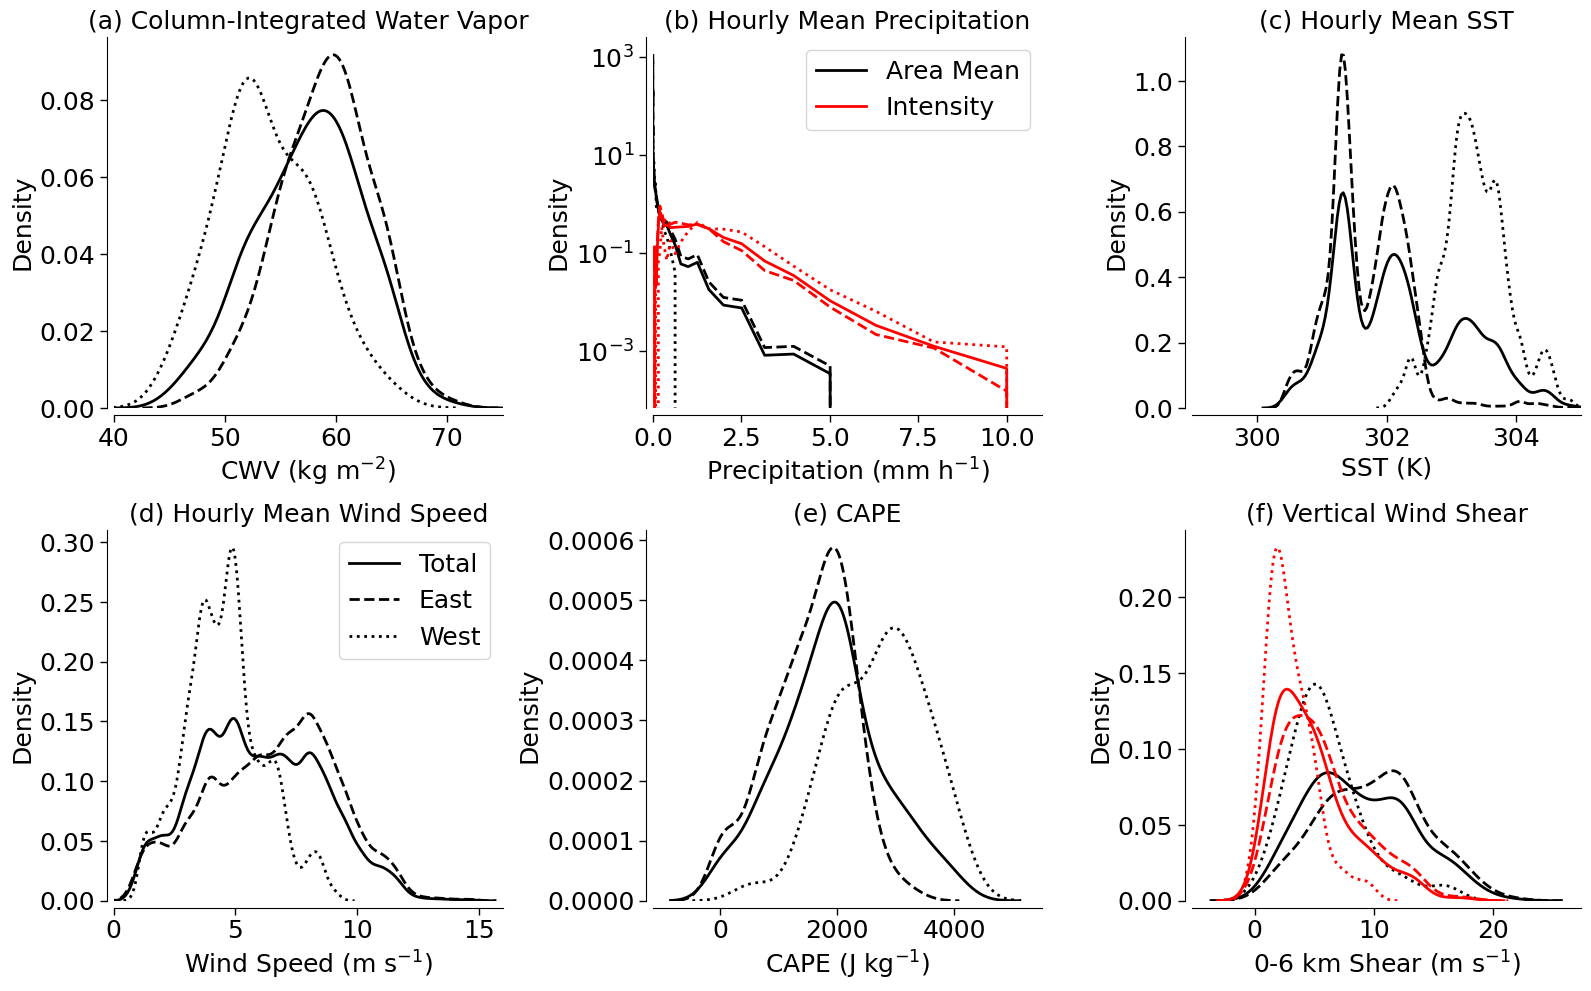

In [45]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

sns.kdeplot(cwv_finite, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(cwvE_finite, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(cwvW_finite, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(40,75)
#axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

#pbins = np.concatenate((np.arange(0,1,0.1),np.arange(1,5,1),np.arange(5,50,5),np.arange(50,250,100)))
pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.1))))
phist1, bin_edges1 = np.histogram(precip2, bins=pbins, density=True)
phist2, bin_edges2 = np.histogram(precipE2, bins=pbins, density=True)
phist3, bin_edges3 = np.histogram(precipW2, bins=pbins, density=True)

phist1a, bin_edges1a = np.histogram(precip2int, bins=pbins, density=True)
phist2a, bin_edges2a = np.histogram(precipE2int, bins=pbins, density=True)
phist3a, bin_edges3a = np.histogram(precipW2int, bins=pbins, density=True)

axs[0,1].plot(bin_edges1[:-1], phist1, color='black', label='Area Mean', linewidth=2)
axs[0,1].plot(bin_edges2[:-1], phist2, color='black', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edges3[:-1], phist3, color='black', linestyle=':', linewidth=2)

axs[0,1].plot(bin_edges1a[:-1], phist1a, color='red', label='Intensity', linewidth=2)
axs[0,1].plot(bin_edges2a[:-1], phist2a, color='red', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edges3a[:-1], phist3a, color='red', linestyle=':', linewidth=2)

#sns.kdeplot(precip, ax=axs[0,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(precipE, ax=axs[0,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(precipW, ax=axs[0,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(0,11)
#axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

sns.kdeplot(sst_smoothed2, ax=axs[0,2],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(sst_smoothedE2, ax=axs[0,2],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(sst_smoothedW2, ax=axs[0,2],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

#sns.kdeplot(sst_smoothed2, ax=axs[1,0],label='Sea Snake',fill=False,common_norm=False,color='red',linewidth=2)
#sns.kdeplot(sst_smoothedE2, ax=axs[1,0],label='East',fill=False,common_norm=False,color='red',linestyle='--',linewidth=2)
#sns.kdeplot(sst_smoothedW2, ax=axs[1,0],label='West',fill=False,common_norm=False,color='red',linestyle=':',linewidth=2)

axs[0,2].set_title('(c) Hourly Mean SST',fontsize=18)
axs[0,2].set_xlabel('SST (K)',fontsize=18)
axs[0,2].set_ylabel('Density',fontsize=18)
axs[0,2].set_xlim(299,305)
#axs[0,2].legend(fontsize=14)
axs[0,2].tick_params(labelsize=18)

sns.kdeplot(wspd_smoothed, ax=axs[1,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(wspd_smoothedE, ax=axs[1,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(wspd_smoothedW, ax=axs[1,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,0].set_title('(d) Hourly Mean Wind Speed',fontsize=18)
axs[1,0].set_xlabel('Wind Speed (m s$^{-1}$)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].legend(fontsize=18,loc='upper right')
axs[1,0].set_xlim(0,16)
axs[1,0].tick_params(labelsize=18)

sns.kdeplot(cape_finite, ax=axs[1,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(capeE_finite, ax=axs[1,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(capeW_finite, ax=axs[1,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,1].set_title('(e) CAPE',fontsize=18)
axs[1,1].set_xlabel('CAPE (J kg$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
#axs[1,1].legend(fontsize=18)
#axs[1,1].set_xlim(0,16)
axs[1,1].tick_params(labelsize=18)

sns.kdeplot(shear06_finite, ax=axs[1,2],label='0-6 km',fill=False,common_norm=False,color='black', linewidth=2)
sns.kdeplot(shear06E_finite, ax=axs[1,2],fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(shear06W_finite, ax=axs[1,2],fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

sns.kdeplot(shear02_finite, ax=axs[1,2],label='0-2 km',fill=False,common_norm=False,color='red',linewidth=2)
sns.kdeplot(shear02E_finite, ax=axs[1,2],fill=False,common_norm=False,color='red',linestyle='--',linewidth=2)
sns.kdeplot(shear02W_finite, ax=axs[1,2],fill=False,common_norm=False,color='red',linestyle=':',linewidth=2)

axs[1,2].set_title('(f) Vertical Wind Shear',fontsize=18)
axs[1,2].set_xlabel('0-6 km Shear (m s$^{-1}$)',fontsize=18)
axs[1,2].set_ylabel('Density',fontsize=18)
#axs[1,2].legend(fontsize=18)
#axs[1,2].set_xlim(0,16)
axs[1,2].tick_params(labelsize=18)


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/Fig_pdf_EW_6panel.png')


## PDF of E/W contrast all from ERA-5

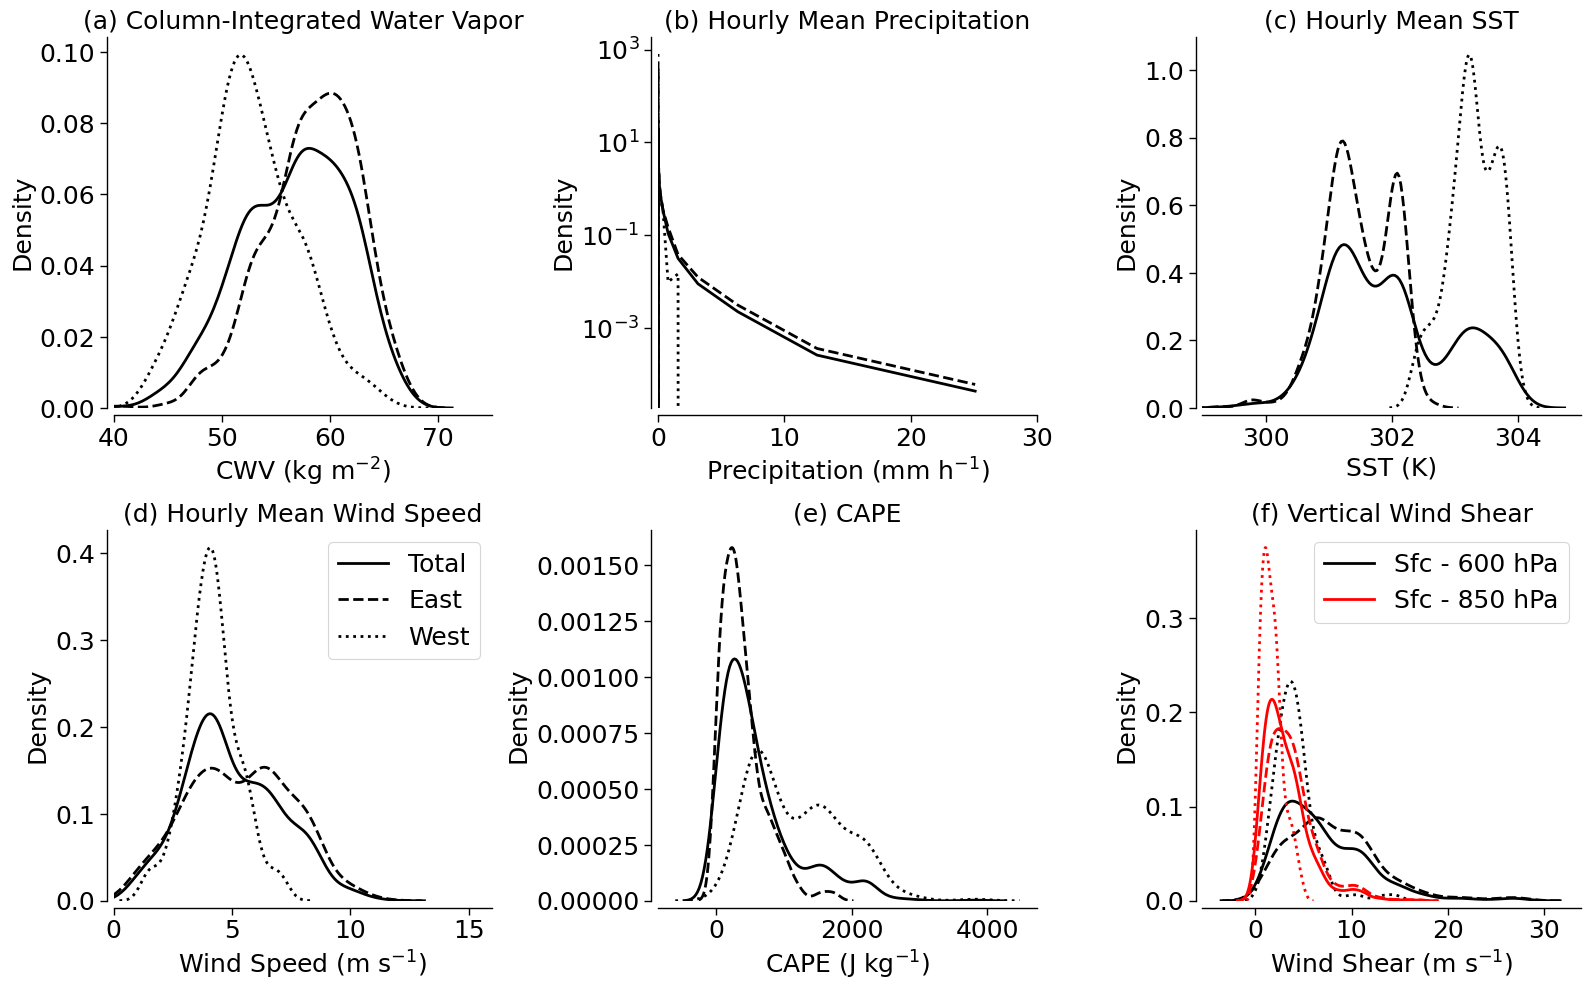

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

sns.kdeplot(IWV_era5, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(IWV_era5E, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(IWV_era5W, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(40,75)
#axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.3))))
phist_era5, bin_edges = np.histogram(prec_era5, bins=pbins, density=True)
phist_era5E, bin_edgesE = np.histogram(prec_era5E, bins=pbins, density=True)
phist_era5W, bin_edgesW = np.histogram(prec_era5W, bins=pbins, density=True)

axs[0,1].plot(bin_edges[:-1], phist_era5, color='black', linewidth=2)
axs[0,1].plot(bin_edgesE[:-1], phist_era5E, color='black', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edgesW[:-1], phist_era5W, color='black', linestyle=':', linewidth=2)

axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(0,30)
#axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
#axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

sns.kdeplot(sst_era5, ax=axs[0,2],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(sst_era5E, ax=axs[0,2],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(sst_era5W, ax=axs[0,2],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,2].set_title('(c) Hourly Mean SST',fontsize=18)
axs[0,2].set_xlabel('SST (K)',fontsize=18)
axs[0,2].set_ylabel('Density',fontsize=18)
axs[0,2].set_xlim(299,305)
#axs[0,2].legend(fontsize=14)
axs[0,2].tick_params(labelsize=18)

sns.kdeplot(wspd_era5, ax=axs[1,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(wspd_era5E, ax=axs[1,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(wspd_era5W, ax=axs[1,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,0].set_title('(d) Hourly Mean Wind Speed',fontsize=18)
axs[1,0].set_xlabel('Wind Speed (m s$^{-1}$)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].legend(fontsize=18,loc='upper right')
axs[1,0].set_xlim(0,16)
axs[1,0].tick_params(labelsize=18)

sns.kdeplot(cape_era5, ax=axs[1,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(cape_era5E, ax=axs[1,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(cape_era5W, ax=axs[1,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,1].set_title('(e) CAPE',fontsize=18)
axs[1,1].set_xlabel('CAPE (J kg$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
#axs[1,1].legend(fontsize=18)
#axs[1,1].set_xlim(0,16)
axs[1,1].tick_params(labelsize=18)

sns.kdeplot(shear06_era5, ax=axs[1,2],label='Sfc - 600 hPa',fill=False,common_norm=False,color='black', linewidth=2)
sns.kdeplot(shear06_era5E, ax=axs[1,2],fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(shear06_era5W, ax=axs[1,2],fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

sns.kdeplot(shear02_era5, ax=axs[1,2],label='Sfc - 850 hPa',fill=False,common_norm=False,color='red',linewidth=2)
sns.kdeplot(shear02_era5E, ax=axs[1,2],fill=False,common_norm=False,color='red',linestyle='--',linewidth=2)
sns.kdeplot(shear02_era5W, ax=axs[1,2],fill=False,common_norm=False,color='red',linestyle=':',linewidth=2)

axs[1,2].set_title('(f) Vertical Wind Shear',fontsize=18)
axs[1,2].set_xlabel('Wind Shear (m s$^{-1}$)',fontsize=18)
axs[1,2].set_ylabel('Density',fontsize=18)
axs[1,2].legend(fontsize=18)
#axs[1,2].set_xlim(0,16)
axs[1,2].tick_params(labelsize=18)


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/Fig_pdf_EW_6panel_era5.png')


# PDF of precip E/W contrast from other spatial scales

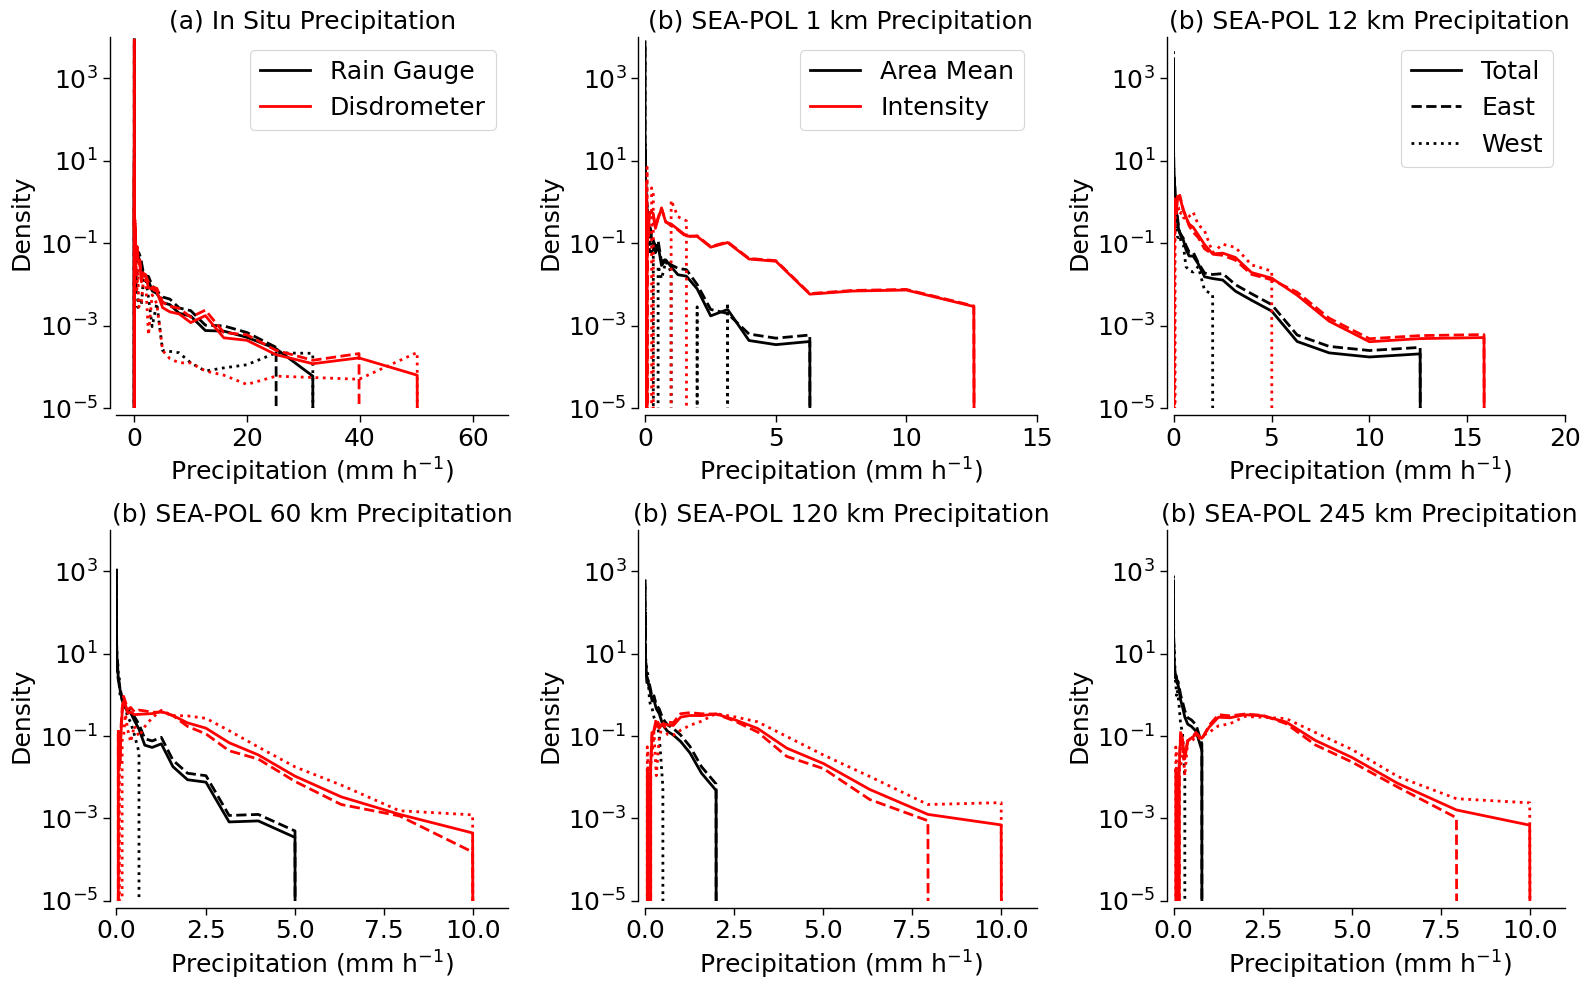

In [47]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.1))))

## Rain Gauge
phist_gauge, bin_edges = np.histogram(precip_gauge, bins=pbins, density=True)
phist_gaugeE, bin_edgesE = np.histogram(precip_gaugeE, bins=pbins, density=True)
phist_gaugeW, bin_edgesW = np.histogram(precip_gaugeW, bins=pbins, density=True)

axs[0,0].plot(bin_edges[:-1], phist_gauge, color='black', label='Rain Gauge', linewidth=2)
axs[0,0].plot(bin_edgesE[:-1], phist_gaugeE, color='black', linestyle='--', linewidth=2)
axs[0,0].plot(bin_edgesW[:-1], phist_gaugeW, color='black', linestyle=':', linewidth=2)

## Disdrometer
phist_disdro, bin_edges = np.histogram(precip, bins=pbins, density=True)
phist_disdroE, bin_edgesE = np.histogram(precipE, bins=pbins, density=True)
phist_disdroW, bin_edgesW = np.histogram(precipW, bins=pbins, density=True)

axs[0,0].plot(bin_edges[:-1], phist_disdro, color='red', label='Disdrometer', linewidth=2)
axs[0,0].plot(bin_edgesE[:-1], phist_disdroE, color='red', linestyle='--', linewidth=2)
axs[0,0].plot(bin_edgesW[:-1], phist_disdroW, color='red', linestyle=':', linewidth=2)

axs[0,0].set_title('(a) In Situ Precipitation',fontsize=18)
axs[0,0].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
#axs[0,0].set_xlim(0,30)
axs[0,0].set_ylim(1e-5,1e4)
axs[0,0].set_yscale('log')
axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

## SEA-POL 1 km
phist_seapol1, bin_edges = np.histogram(precip_seapol1, bins=pbins, density=True)
phist_seapol1E, bin_edgesE = np.histogram(precip_seapol1E, bins=pbins, density=True)
phist_seapol1W, bin_edgesW = np.histogram(precip_seapol1W, bins=pbins, density=True)

phist_seapol1a, bin_edges1a = np.histogram(precip_seapol1int, bins=pbins, density=True)
phist_seapol1Ea, bin_edges1aE = np.histogram(precip_seapol1Eint, bins=pbins, density=True)
phist_seapol1Wa, bin_edges1aW = np.histogram(precip_seapol1Wint, bins=pbins, density=True)

axs[0,1].plot(bin_edges[:-1], phist_seapol1, color='black', label='Area Mean', linewidth=2)
axs[0,1].plot(bin_edgesE[:-1], phist_seapol1E, color='black', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edgesW[:-1], phist_seapol1W, color='black', linestyle=':', linewidth=2)

axs[0,1].plot(bin_edges1a[:-1], phist_seapol1a, color='red', label='Intensity', linewidth=2)
axs[0,1].plot(bin_edges1aE[:-1], phist_seapol1Ea, color='red', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edges1aW[:-1], phist_seapol1Wa, color='red', linestyle=':', linewidth=2)

axs[0,1].set_title('(b) SEA-POL 1 km Precipitation',fontsize=18)
axs[0,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(0,15)
axs[0,1].set_ylim(1e-5,1e4)
axs[0,1].set_yscale('log')
axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(precip_seapol12, bins=pbins, density=True)
phist_seapol12E, bin_edgesE = np.histogram(precip_seapol12E, bins=pbins, density=True)
phist_seapol12W, bin_edgesW = np.histogram(precip_seapol12W, bins=pbins, density=True)

phist_seapol12a, bin_edges1a = np.histogram(precip_seapol12int, bins=pbins, density=True)
phist_seapol12Ea, bin_edges1aE = np.histogram(precip_seapol12Eint, bins=pbins, density=True)
phist_seapol12Wa, bin_edges1aW = np.histogram(precip_seapol12Wint, bins=pbins, density=True)

axs[0,2].plot(bin_edges[:-1], phist_seapol12, color='black', label='Total', linewidth=2)
axs[0,2].plot(bin_edgesE[:-1], phist_seapol12E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,2].plot(bin_edgesW[:-1], phist_seapol12W, color='black', linestyle=':', label = 'West', linewidth=2)

axs[0,2].plot(bin_edges1a[:-1], phist_seapol12a, color='red', linewidth=2)
axs[0,2].plot(bin_edges1aE[:-1], phist_seapol12Ea, color='red', linestyle='--', linewidth=2)
axs[0,2].plot(bin_edges1aW[:-1], phist_seapol12Wa, color='red', linestyle=':', linewidth=2)

axs[0,2].set_title('(b) SEA-POL 12 km Precipitation',fontsize=18)
axs[0,2].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,2].set_ylabel('Density',fontsize=18)
axs[0,2].set_xlim(0,20)
axs[0,2].set_ylim(1e-5,1e4)
axs[0,2].set_yscale('log')
axs[0,2].legend(fontsize=18)
axs[0,2].tick_params(labelsize=18)

## SEA-POL 60 km
phist1, bin_edges1 = np.histogram(precip2, bins=pbins, density=True)
phist2, bin_edges2 = np.histogram(precipE2, bins=pbins, density=True)
phist3, bin_edges3 = np.histogram(precipW2, bins=pbins, density=True)

phist1a, bin_edges1a = np.histogram(precip2int, bins=pbins, density=True)
phist2a, bin_edges2a = np.histogram(precipE2int, bins=pbins, density=True)
phist3a, bin_edges3a = np.histogram(precipW2int, bins=pbins, density=True)

axs[1,0].plot(bin_edges1[:-1], phist1, color='black', label='Area Mean', linewidth=2)
axs[1,0].plot(bin_edges2[:-1], phist2, color='black', linestyle='--', linewidth=2)
axs[1,0].plot(bin_edges3[:-1], phist3, color='black', linestyle=':', linewidth=2)

axs[1,0].plot(bin_edges1a[:-1], phist1a, color='red', label='Intensity', linewidth=2)
axs[1,0].plot(bin_edges2a[:-1], phist2a, color='red', linestyle='--', linewidth=2)
axs[1,0].plot(bin_edges3a[:-1], phist3a, color='red', linestyle=':', linewidth=2)

axs[1,0].set_title('(b) SEA-POL 60 km Precipitation',fontsize=18)
axs[1,0].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].set_xlim(0,11)
axs[1,0].set_ylim(1e-5,1e4)
axs[1,0].set_yscale('log')
#axs[1,0].legend(fontsize=18)
axs[1,0].tick_params(labelsize=18)

## SEA-POL 120 km
phist_seapol120, bin_edges = np.histogram(precip_seapol120, bins=pbins, density=True)
phist_seapol120E, bin_edgesE = np.histogram(precip_seapol120E, bins=pbins, density=True)
phist_seapol120W, bin_edgesW = np.histogram(precip_seapol120W, bins=pbins, density=True)

phist_seapol120a, bin_edges1a = np.histogram(precip_seapol120int, bins=pbins, density=True)
phist_seapol120Ea, bin_edges1aE = np.histogram(precip_seapol120Eint, bins=pbins, density=True)
phist_seapol120Wa, bin_edges1aW = np.histogram(precip_seapol120Wint, bins=pbins, density=True)

axs[1,1].plot(bin_edges[:-1], phist_seapol120, color='black', label='Total', linewidth=2)
axs[1,1].plot(bin_edgesE[:-1], phist_seapol120E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[1,1].plot(bin_edgesW[:-1], phist_seapol120W, color='black', linestyle=':', label = 'West', linewidth=2)

axs[1,1].plot(bin_edges1a[:-1], phist_seapol120a, color='red', label='Intensity', linewidth=2)
axs[1,1].plot(bin_edges1aE[:-1], phist_seapol120Ea, color='red', linestyle='--', label = 'East', linewidth=2)
axs[1,1].plot(bin_edges1aW[:-1], phist_seapol120Wa, color='red', linestyle=':', label = 'West', linewidth=2)

axs[1,1].set_title('(b) SEA-POL 120 km Precipitation',fontsize=18)
axs[1,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
axs[1,1].set_xlim(0,11)
axs[1,1].set_ylim(1e-5,1e4)
axs[1,1].set_yscale('log')
#axs[1,1].legend(fontsize=18)
axs[1,1].tick_params(labelsize=18)

## SEA-POL 245 km
phist_seapol245, bin_edges = np.histogram(precip_seapol245, bins=pbins, density=True)
phist_seapol245E, bin_edgesE = np.histogram(precip_seapol245E, bins=pbins, density=True)
phist_seapol245W, bin_edgesW = np.histogram(precip_seapol245W, bins=pbins, density=True)

phist_seapol245a, bin_edges1a = np.histogram(precip_seapol245int, bins=pbins, density=True)
phist_seapol245Ea, bin_edges1aE = np.histogram(precip_seapol245Eint, bins=pbins, density=True)
phist_seapol245Wa, bin_edges1aW = np.histogram(precip_seapol245Wint, bins=pbins, density=True)

axs[1,2].plot(bin_edges[:-1], phist_seapol245, color='black', label='Total', linewidth=2)
axs[1,2].plot(bin_edgesE[:-1], phist_seapol245E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[1,2].plot(bin_edgesW[:-1], phist_seapol245W, color='black', linestyle=':', label = 'West', linewidth=2)

axs[1,2].plot(bin_edges1a[:-1], phist_seapol245a, color='red', label='Intensity', linewidth=2)
axs[1,2].plot(bin_edges1aE[:-1], phist_seapol245Ea, color='red', linestyle='--', label = 'East', linewidth=2)
axs[1,2].plot(bin_edges1aW[:-1], phist_seapol245Wa, color='red', linestyle=':', label = 'West', linewidth=2)

axs[1,2].set_title('(b) SEA-POL 245 km Precipitation',fontsize=18)
axs[1,2].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,2].set_ylabel('Density',fontsize=18)
axs[1,2].set_xlim(0,11)
axs[1,2].set_ylim(1e-5,1e4)
axs[1,2].set_yscale('log')
#axs[1,2].legend(fontsize=18)
axs[1,2].tick_params(labelsize=18)


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/SEAPOL/Fig_pdf_EW_precip.png')


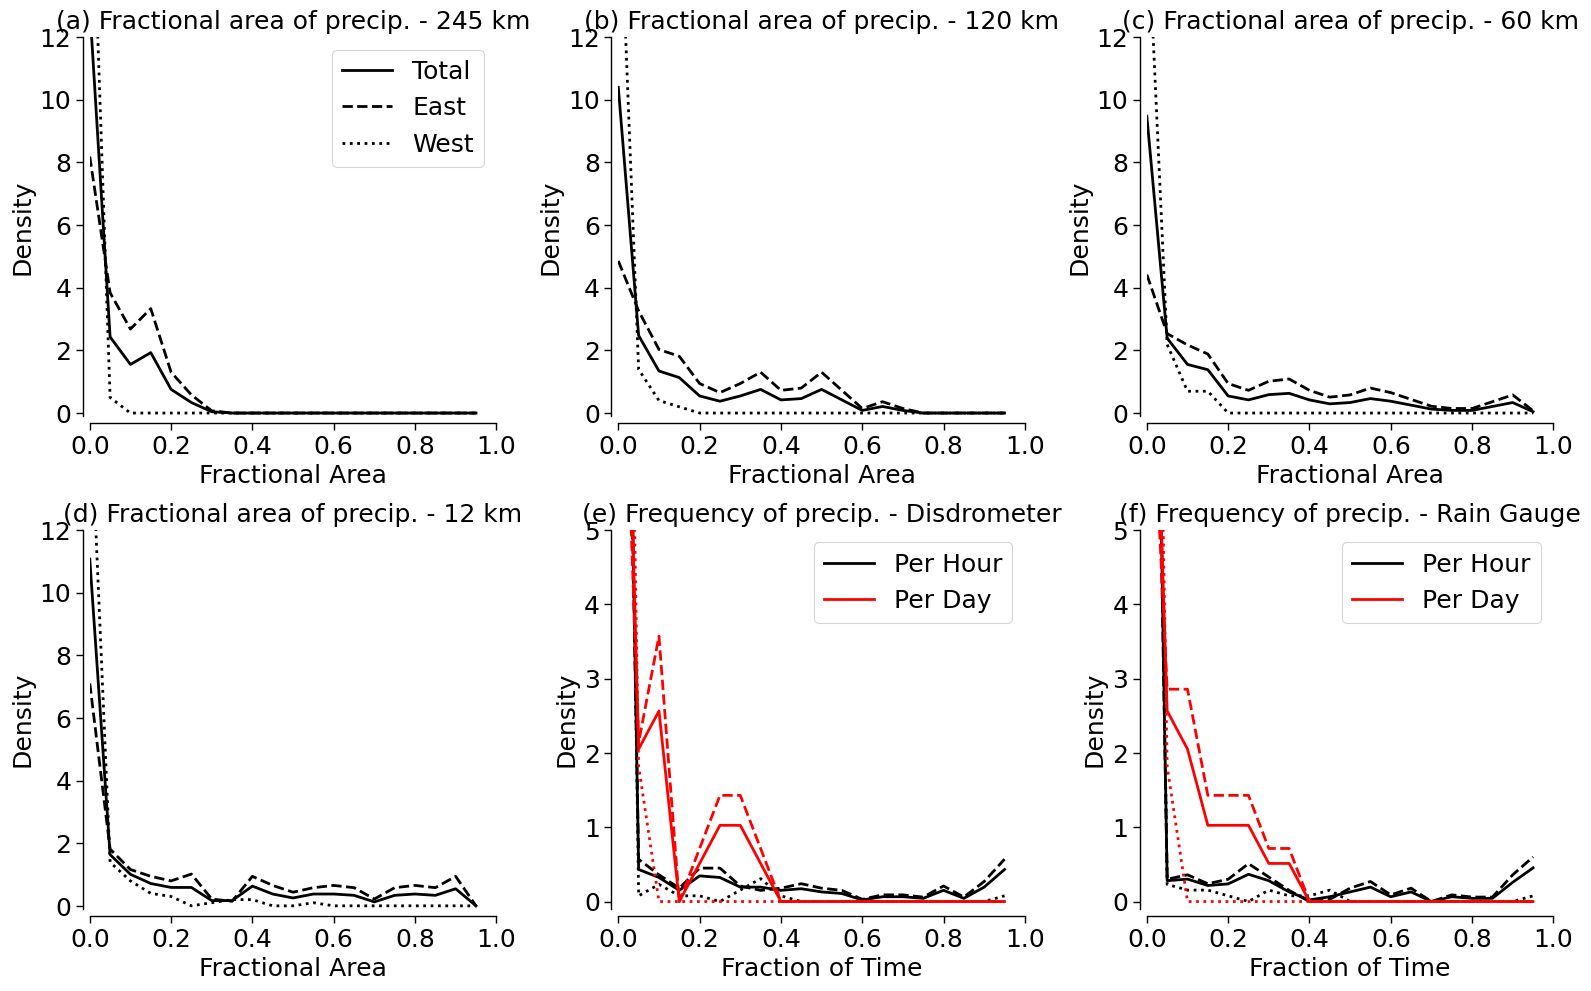

In [49]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.1))))

## Fractional area 245 km
fabins = np.arange(0,1.05,0.05)
phist_fa245, bin_edges = np.histogram(fa245, bins=fabins, density=True)
phist_fa245E, bin_edgesE = np.histogram(fa245E, bins=fabins, density=True)
phist_fa245W, bin_edgesW = np.histogram(fa245W, bins=fabins, density=True)

axs[0,0].plot(bin_edges[:-1], phist_fa245, color='black', label='Total', linewidth=2)
axs[0,0].plot(bin_edgesE[:-1], phist_fa245E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,0].plot(bin_edgesW[:-1], phist_fa245W, color='black', linestyle=':', label = 'West', linewidth=2)

#sns.kdeplot(fa245, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(fa245E, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(fa245W, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) Fractional area of precip. - 245 km',fontsize=18)
axs[0,0].set_xlabel('Fractional Area',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(0,1)
axs[0,0].set_ylim(-0.1,12)
axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

## Fractional area 120 km
phist_fa120, bin_edges = np.histogram(fa120, bins=fabins, density=True)
phist_fa120E, bin_edgesE = np.histogram(fa120E, bins=fabins, density=True)
phist_fa120W, bin_edgesW = np.histogram(fa120W, bins=fabins, density=True)

axs[0,1].plot(bin_edges[:-1], phist_fa120, color='black', label='Total', linewidth=2)
axs[0,1].plot(bin_edgesE[:-1], phist_fa120E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,1].plot(bin_edgesW[:-1], phist_fa120W, color='black', linestyle=':', label = 'West', linewidth=2)

#sns.kdeplot(fa120, ax=axs[0,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(fa120E, ax=axs[0,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(fa120W, ax=axs[0,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,1].set_title('(b) Fractional area of precip. - 120 km',fontsize=18)
axs[0,1].set_xlabel('Fractional Area',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(0,1)
axs[0,1].set_ylim(-0.1,12)
#axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

## Fractional area 60 km
phist_fa60, bin_edges = np.histogram(fa60, bins=fabins, density=True)
phist_fa60E, bin_edgesE = np.histogram(fa60E, bins=fabins, density=True)
phist_fa60W, bin_edgesW = np.histogram(fa60W, bins=fabins, density=True)

axs[0,2].plot(bin_edges[:-1], phist_fa60, color='black', label='Total', linewidth=2)
axs[0,2].plot(bin_edgesE[:-1], phist_fa60E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,2].plot(bin_edgesW[:-1], phist_fa60W, color='black', linestyle=':', label = 'West', linewidth=2)

#sns.kdeplot(fa60, ax=axs[0,2],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(fa60E, ax=axs[0,2],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(fa60W, ax=axs[0,2],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,2].set_title('(c) Fractional area of precip. - 60 km',fontsize=18)
axs[0,2].set_xlabel('Fractional Area',fontsize=18)
axs[0,2].set_ylabel('Density',fontsize=18)
axs[0,2].set_xlim(0,1)
axs[0,2].set_ylim(-0.1,12)
#axs[0,2].legend(fontsize=18)
axs[0,2].tick_params(labelsize=18)

## Fractional area 12 km
phist_fa12, bin_edges = np.histogram(fa12, bins=fabins, density=True)
phist_fa12E, bin_edgesE = np.histogram(fa12E, bins=fabins, density=True)
phist_fa12W, bin_edgesW = np.histogram(fa12W, bins=fabins, density=True)

axs[1,0].plot(bin_edges[:-1], phist_fa12, color='black', label='Total', linewidth=2)
axs[1,0].plot(bin_edgesE[:-1], phist_fa12E, color='black', linestyle='--', label = 'East', linewidth=2)
axs[1,0].plot(bin_edgesW[:-1], phist_fa12W, color='black', linestyle=':', label = 'West', linewidth=2)

#sns.kdeplot(fa12, ax=axs[1,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(fa12E, ax=axs[1,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(fa12W, ax=axs[1,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,0].set_title('(d) Fractional area of precip. - 12 km',fontsize=18)
axs[1,0].set_xlabel('Fractional Area',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(-0.1,12)
#axs[1,0].legend(fontsize=18)
axs[1,0].tick_params(labelsize=18)

## Time frequency of precip from disdrometer
phist_fp_disdro_hrly, bin_edges = np.histogram(precip_freq_disdro, bins=fabins, density=True)
phist_fp_disdro_hrlyE, bin_edgesE = np.histogram(precip_freq_disdroE, bins=fabins, density=True)
phist_fp_disdro_hrlyW, bin_edgesW = np.histogram(precip_freq_disdroW, bins=fabins, density=True)

phist_fp_disdro_daily, bin_edges1a = np.histogram(precip_freq_disdro_daily, bins=fabins, density=True)
phist_fp_disdro_dailyE, bin_edges1aE = np.histogram(precip_freq_disdro_dailyE, bins=fabins, density=True)
phist_fp_disdro_dailyW, bin_edges1aW = np.histogram(precip_freq_disdro_dailyW, bins=fabins, density=True)

axs[1,1].plot(bin_edges[:-1], phist_fp_disdro_hrly, color='black', label='Per Hour', linewidth=2)
axs[1,1].plot(bin_edgesE[:-1], phist_fp_disdro_hrlyE, color='black', linestyle='--', linewidth=2)
axs[1,1].plot(bin_edgesW[:-1], phist_fp_disdro_hrlyW, color='black', linestyle=':', linewidth=2)

axs[1,1].plot(bin_edges1a[:-1], phist_fp_disdro_daily, color='red', label='Per Day', linewidth=2)
axs[1,1].plot(bin_edges1aE[:-1], phist_fp_disdro_dailyE, color='red', linestyle='--', linewidth=2)
axs[1,1].plot(bin_edges1aW[:-1], phist_fp_disdro_dailyW, color='red', linestyle=':', linewidth=2)

axs[1,1].set_title('(e) Frequency of precip. - Disdrometer',fontsize=18)
axs[1,1].set_xlabel('Fraction of Time',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(-0.1,5)
axs[1,1].legend(fontsize=18)
axs[1,1].tick_params(labelsize=18)

## Time frequency of precip from rain gauge
phist_fp_gauge_hrly, bin_edges = np.histogram(precip_freq_gauge, bins=fabins, density=True)
phist_fp_gauge_hrlyE, bin_edgesE = np.histogram(precip_freq_gaugeE, bins=fabins, density=True)
phist_fp_gauge_hrlyW, bin_edgesW = np.histogram(precip_freq_gaugeW, bins=fabins, density=True)

phist_fp_gauge_daily, bin_edges1a = np.histogram(precip_freq_gauge_daily, bins=fabins, density=True)
phist_fp_gauge_dailyE, bin_edges1aE = np.histogram(precip_freq_gauge_dailyE, bins=fabins, density=True)
phist_fp_gauge_dailyW, bin_edges1aW = np.histogram(precip_freq_gauge_dailyW, bins=fabins, density=True)

axs[1,2].plot(bin_edges[:-1], phist_fp_gauge_hrly, color='black', label='Per Hour', linewidth=2)
axs[1,2].plot(bin_edgesE[:-1], phist_fp_gauge_hrlyE, color='black', linestyle='--', linewidth=2)
axs[1,2].plot(bin_edgesW[:-1], phist_fp_gauge_hrlyW, color='black', linestyle=':', linewidth=2)

axs[1,2].plot(bin_edges1a[:-1], phist_fp_gauge_daily, color='red', label='Per Day', linewidth=2)
axs[1,2].plot(bin_edges1aE[:-1], phist_fp_gauge_dailyE, color='red', linestyle='--', linewidth=2)
axs[1,2].plot(bin_edges1aW[:-1], phist_fp_gauge_dailyW, color='red', linestyle=':', linewidth=2)

axs[1,2].set_title('(f) Frequency of precip. - Rain Gauge',fontsize=18)
axs[1,2].set_xlabel('Fraction of Time',fontsize=18)
axs[1,2].set_ylabel('Density',fontsize=18)
axs[1,2].set_xlim(0,1)
axs[1,2].set_ylim(-0.1,5)
axs[1,2].legend(fontsize=18)
axs[1,2].tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/SEAPOL/Fig_pdf_EW_precip_fa.png')


# plot of E/W contrast of along-track data from ERA-5 and MIMIC-TPW

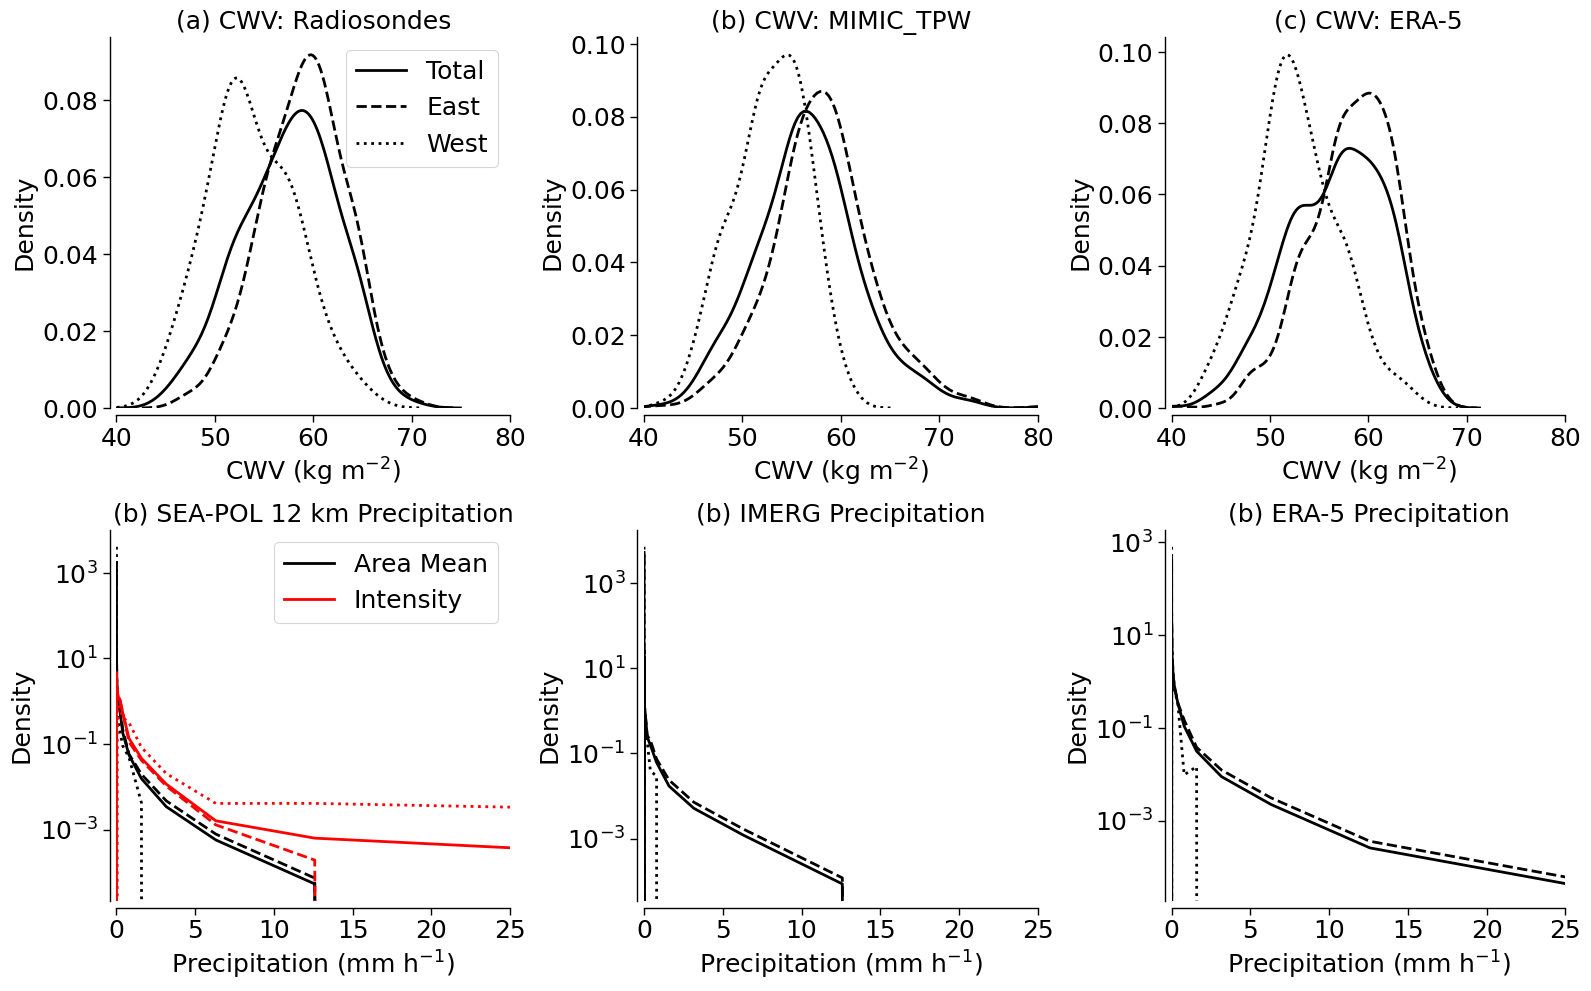

In [85]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

sns.kdeplot(cwv_finite, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(cwvE_finite, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(cwvW_finite, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) CWV: Radiosondes',fontsize=18)
axs[0,0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(40,80)
axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

sns.kdeplot(IWV_mimic, ax=axs[0,1],label='MIMIC',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(IWV_mimicE, ax=axs[0,1],label='MIMIC East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(IWV_mimicW, ax=axs[0,1],label='MIMIC West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,1].set_title('(b) CWV: MIMIC_TPW',fontsize=18)
axs[0,1].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(40,80)
#axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

sns.kdeplot(IWV_era5, ax=axs[0,2],label='ERA5',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(IWV_era5E, ax=axs[0,2],label='ERA5 East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(IWV_era5W, ax=axs[0,2],label='ERA5 West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,2].set_title('(c) CWV: ERA-5',fontsize=18)
axs[0,2].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,2].set_ylabel('Density',fontsize=18)
axs[0,2].set_xlim(40,80)
#axs[0,2].legend(fontsize=18)
axs[0,2].tick_params(labelsize=18)

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.3))))

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(precip_seapol12, bins=pbins, density=True)
phist_seapol12E, bin_edgesE = np.histogram(precip_seapol12E, bins=pbins, density=True)
phist_seapol12W, bin_edgesW = np.histogram(precip_seapol12W, bins=pbins, density=True)

phist_seapol12a, bin_edges1a = np.histogram(precip_seapol12int, bins=pbins, density=True)
phist_seapol12Ea, bin_edges1aE = np.histogram(precip_seapol12Eint, bins=pbins, density=True)
phist_seapol12Wa, bin_edges1aW = np.histogram(precip_seapol12Wint, bins=pbins, density=True)

axs[1,0].plot(bin_edges[:-1], phist_seapol12, color='black', label='Area Mean', linewidth=2)
axs[1,0].plot(bin_edgesE[:-1], phist_seapol12E, color='black', linestyle='--', linewidth=2)
axs[1,0].plot(bin_edgesW[:-1], phist_seapol12W, color='black', linestyle=':', linewidth=2)

axs[1,0].plot(bin_edges1a[:-1], phist_seapol12a, color='red', label='Intensity', linewidth=2)
axs[1,0].plot(bin_edges1aE[:-1], phist_seapol12Ea, color='red', linestyle='--', linewidth=2)
axs[1,0].plot(bin_edges1aW[:-1], phist_seapol12Wa, color='red', linestyle=':', linewidth=2)

axs[1,0].set_title('(b) SEA-POL 12 km Precipitation',fontsize=18)
axs[1,0].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].set_xlim(0,25)
#axs[1,0].set_ylim(1e-5,1e4)
axs[1,0].set_yscale('log')
axs[1,0].legend(fontsize=18)
axs[1,0].tick_params(labelsize=18)

## IMERG
phist_imerg, bin_edges = np.histogram(prec_imerg, bins=pbins, density=True)
phist_imergE, bin_edgesE = np.histogram(prec_imergE, bins=pbins, density=True)
phist_imergW, bin_edgesW = np.histogram(prec_imergW, bins=pbins, density=True)

axs[1,1].plot(bin_edges[:-1], phist_imerg, color='black', linewidth=2)
axs[1,1].plot(bin_edgesE[:-1], phist_imergE, color='black', linestyle='--', linewidth=2)
axs[1,1].plot(bin_edgesW[:-1], phist_imergW, color='black', linestyle=':', linewidth=2)

axs[1,1].set_title('(b) IMERG Precipitation',fontsize=18)
axs[1,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
axs[1,1].set_xlim(0,25)
#axs[1,1].set_ylim(1e-5,1e4)
axs[1,1].set_yscale('log')
#axs[1,1].legend(fontsize=18)
axs[1,1].tick_params(labelsize=18)

## ERA-5
phist_era5, bin_edges = np.histogram(prec_era5, bins=pbins, density=True)
phist_era5E, bin_edgesE = np.histogram(prec_era5E, bins=pbins, density=True)
phist_era5W, bin_edgesW = np.histogram(prec_era5W, bins=pbins, density=True)

axs[1,2].plot(bin_edges[:-1], phist_era5, color='black', linewidth=2)
axs[1,2].plot(bin_edgesE[:-1], phist_era5E, color='black', linestyle='--', linewidth=2)
axs[1,2].plot(bin_edgesW[:-1], phist_era5W, color='black', linestyle=':', linewidth=2)

axs[1,2].set_title('(b) ERA-5 Precipitation',fontsize=18)
axs[1,2].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[1,2].set_ylabel('Density',fontsize=18)
axs[1,2].set_xlim(0,25)
#axs[1,2].set_ylim(1e-5,1e4)
axs[1,2].set_yscale('log')
#axs[1,2].legend(fontsize=18)
axs[1,2].tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_pdf_EW_CWV_precip.png')


## E/W contrast over all years

Load imerg alongtrack data for all years

In [39]:
# Load IMERG alongtrack data
imerg_alongtrack = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/imerg/prec_alongtrack.nc')
imerg_alongtrack

<xarray.Dataset> Size: 223kB
Dimensions:        (year: 27, time: 927)
Coordinates:
  * year           (year) int64 216B 1998 1999 2000 2001 ... 2021 2022 2023 2024
  * time           (time) datetime64[ns] 7kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables:
    precipitation  (year, time) float64 200kB ...
    ship_lat       (time) float64 7kB ...
    ship_lon       (time) float64 7kB ...
Attributes:
    description:  IMERG precipitation along ship track
    source:       IMERG v07 Final Run
    history:      Created 2025-06-25 by Allison Wing

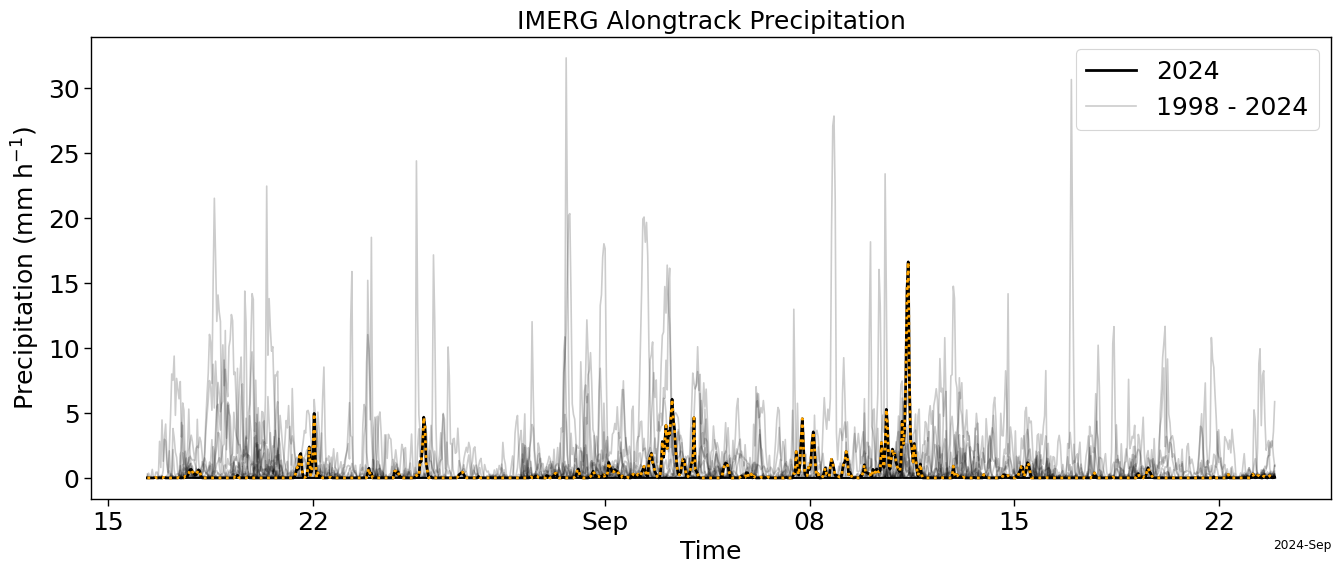

In [41]:
# plot time series of alongtrack data
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(ship_time_interp,IWValong_track.precip_alongtrack_imerg.values, label = '2024', color='black', linewidth=2)

years_imerg = np.arange(1998, 2025)  # Adjusted to match the dataset years
for i in range(len(years_imerg)):
    if years_imerg[i] == 2024:
        ax.plot(ship_time_interp,imerg_alongtrack.precipitation[i,:], color='orange', linestyle=':',linewidth=2)
    elif i==0:
        ax.plot(ship_time_interp,imerg_alongtrack.precipitation[i,:], label = str(years_imerg[0]) + ' - ' + str(years_imerg[-1]), color='black', alpha=0.2)
    else:
        ax.plot(ship_time_interp,imerg_alongtrack.precipitation[i,:], color='black', alpha=0.2)
    
ax.set_title('IMERG Alongtrack Precipitation', fontsize=18)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Precipitation (mm h$^{-1}$)', fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize = 18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

In [42]:
# Split into East/West
prec_imerg_all = imerg_alongtrack.precipitation
prec_imerg_allE = prec_imerg_all[:,imerg_alongtrack.ship_lon > lonEW]
prec_imerg_allW = prec_imerg_all[:,imerg_alongtrack.ship_lon <= lonEW]
prec_imerg_allC = prec_imerg_all[:,(imerg_alongtrack.ship_lon > lonEW) & (imerg_alongtrack.ship_lon <= lonC)]
prec_imerg_allEE = prec_imerg_all[:,imerg_alongtrack.ship_lon > lonC]

# Take climo mean
prec_imerg_climo = prec_imerg_all.mean(dim='year', skipna=True)
prec_imerg_climoE = prec_imerg_allE.mean(dim='year', skipna=True)
prec_imerg_climoW = prec_imerg_allW.mean(dim='year', skipna=True)

In [43]:
prec_imerg_meanE = prec_imerg_allE.mean(dim='time', skipna=True)
prec_imerg_meanW = prec_imerg_allW.mean(dim='time', skipna=True)
prec_imerg_meanC = prec_imerg_allC.mean(dim='time', skipna=True)   
prec_imerg_meanEE = prec_imerg_allEE.mean(dim='time', skipna=True)

prec_imerg_EWdiff = prec_imerg_meanE - prec_imerg_meanW
prec_imerg_EWdiff

<xarray.DataArray 'precipitation' (year: 27)> Size: 216B
array([ 0.15064605,  0.22015728, -0.16091487, -0.14789487,  0.16699226,
        0.22552348,  0.545528  , -0.05924986,  0.02902729,  0.10438985,
        0.09666608,  0.35395017, -0.01544175,  0.47952165, -0.00768482,
       -0.11031561, -0.10899934,  0.29524465,  0.41146263,  0.25120349,
        0.21069158, -0.3256635 ,  0.13802805,  0.34363962,  0.05412436,
        0.12714188,  0.37533595])
Coordinates:
  * year     (year) int64 216B 1998 1999 2000 2001 2002 ... 2021 2022 2023 2024

In [44]:
prec_imerg_ECdiff = prec_imerg_meanEE - prec_imerg_meanC
prec_imerg_ECdiff

<xarray.DataArray 'precipitation' (year: 27)> Size: 216B
array([-0.06985738, -0.14836564, -0.02349088, -0.12497802, -0.42314275,
        0.24770097,  0.41473332, -0.0445732 ,  0.01658484, -0.15781046,
        0.17377536, -0.12665464,  0.1943954 , -0.13873314,  0.28028269,
       -0.07348355,  0.73047328,  0.29659889, -0.26747548, -0.40092565,
       -0.32932073, -0.13731073,  0.121902  ,  0.54595196,  0.18792937,
       -0.49614367, -0.64171569])
Coordinates:
  * year     (year) int64 216B 1998 1999 2000 2001 2002 ... 2021 2022 2023 2024

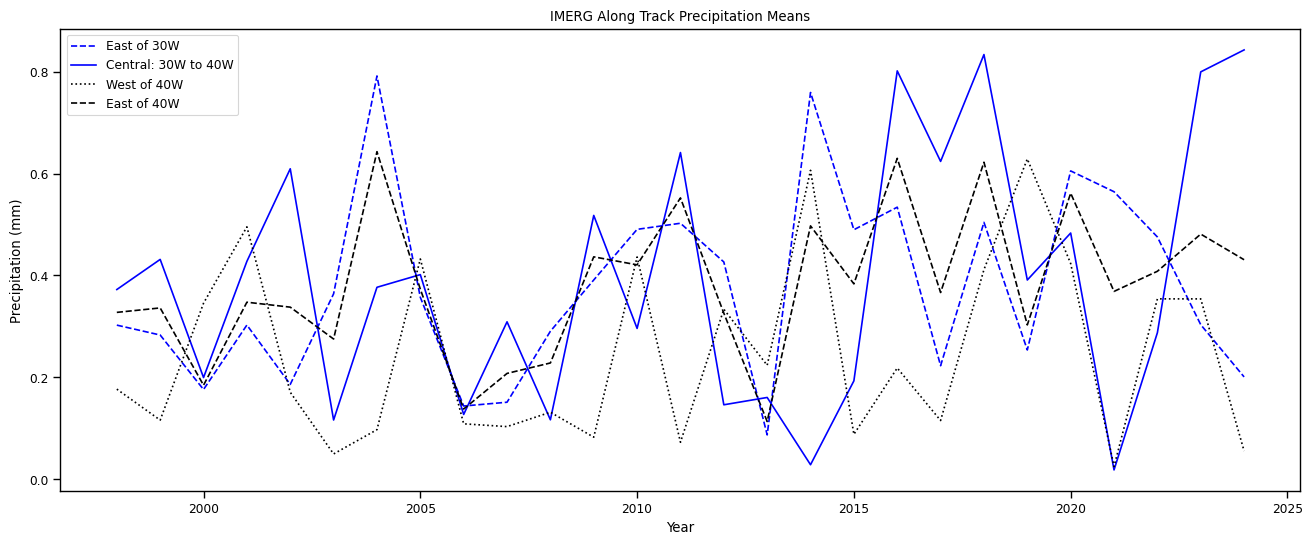

In [45]:
# plot E,W,C means
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(imerg_alongtrack.year,prec_imerg_meanEE, label='East of 30W', color='blue',linestyle = '--')
ax.plot(imerg_alongtrack.year,prec_imerg_meanC, label='Central: 30W to 40W', color='blue')
ax.plot(imerg_alongtrack.year,prec_imerg_meanW, label='West of 40W', color='black', linestyle = ':')
ax.plot(imerg_alongtrack.year,prec_imerg_meanE, label='East of 40W', color='black', linestyle = '--')
ax.set_title('IMERG Along Track Precipitation Means')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
ax.legend()

Plot

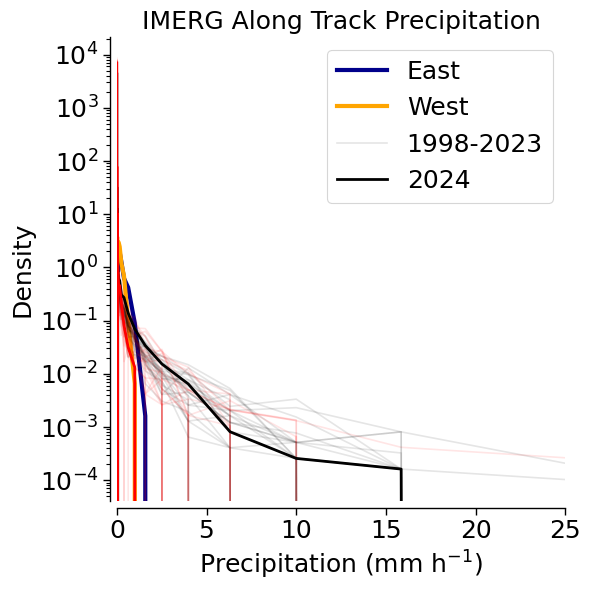

In [50]:
fig, ax = plt.subplots(figsize=(6,6))

# Define bins
pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.2))))

# Histogram for climo mean
phist_imerg, bin_edges = np.histogram(prec_imerg_climo, bins=pbins, density=True)
phist_imergE, bin_edgesE = np.histogram(prec_imerg_climoE, bins=pbins, density=True)
phist_imergW, bin_edgesW = np.histogram(prec_imerg_climoW, bins=pbins, density=True)

#ax.plot(bin_edges[:-1], phist_imerg, label = 'Climo. Mean', color='darkblue', linewidth=2)
ax.plot(bin_edgesE[:-1], phist_imergE, label = 'East', color='darkblue', linestyle='-', linewidth=3)
ax.plot(bin_edgesW[:-1], phist_imergW, label = 'West', color='orange', linestyle='-', linewidth=3)

#years_imerg = imerg_alongtrack.years.values
years_imerg = np.arange(1998, 2025)  # Adjusted to match the dataset years
for i in range(len(years_imerg)):
    #Calculate histogram for this year
    #phist_imerg, bin_edges = np.histogram(prec_imerg_all.sel(year=years_imerg[i]), bins=pbins, density=True)
    phist_imergE, bin_edgesE = np.histogram(prec_imerg_allE.sel(year=years_imerg[i]), bins=pbins, density=True)
    phist_imergW, bin_edgesW = np.histogram(prec_imerg_allW.sel(year=years_imerg[i]), bins=pbins, density=True)
    
    #Add to plot
    if i == 0: #label the first year
        #ax.plot(bin_edges[:-1],phist_imerg,label=str(years_imerg[0]) + '-' + str(years_imerg[-2]),color='k',alpha=0.1,linestyle='-')
        ax.plot(bin_edgesE[:-1],phist_imergE,label=str(years_imerg[0]) + '-' + str(years_imerg[-2]), color='k',alpha=0.1,linestyle='-')
        ax.plot(bin_edgesW[:-1],phist_imergW,color='r',alpha=0.1,linestyle='-')
    elif i == len(years_imerg)-1: #last year plotted bolder
        #ax.plot(bin_edges[:-1],phist_imerg,label=str(years_imerg[-1]),color='k',linestyle='-')
        ax.plot(bin_edgesE[:-1],phist_imergE,label=str(years_imerg[i]),color='k',linestyle='-',linewidth=2)
        ax.plot(bin_edgesW[:-1],phist_imergW,color='r',linestyle='-',linewidth=2)
    else: #all other years
        #ax.plot(bin_edges[:-1],phist_imerg,color='k',alpha=0.1,linestyle='-')
        ax.plot(bin_edgesE[:-1],phist_imergE,color='k',alpha=0.1,linestyle='-')
        ax.plot(bin_edgesW[:-1],phist_imergW,color='r',alpha=0.1,linestyle='-')

#Plot attributes
ax.set_title('IMERG Along Track Precipitation',fontsize=18)
ax.set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
ax.set_ylabel('Density',fontsize=18)
ax.set_xlim(0,25)
ax.set_yscale('log')
ax.tick_params(labelsize=18)
ax.legend(fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/Fig_pdf_EW_precip_allyears.png')